# Dataset

The historical dataset of ^SOX, ^VIX and BTC-USD prices were obtained using the Yahoo Finance API **`yfinance`** at 1-day interval.

## 1.1 Installing & Importing Libraries 

In [1]:
# !pip install arch

In [2]:
# !pip3 install yfinance

In [3]:
# !pip install tensorflow

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
from scipy import stats

%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1.2 Load Data

In [7]:
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
pd.set_option('display.max_colwidth', None)

In [8]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('..', '..', 'images')

In [9]:
# SET SEED FOR REPRODUCIBILITY
seed = 2021

In [10]:
# SET START AND END DATE
start = datetime(2015, 1, 1)
end = datetime(2022, 12, 31)

### 1.2.1 VIX Index Data

In [11]:
tckr_VIX = '^VIX'

ticker_VIX = yf.Ticker(tckr_VIX)

df_VIX = ticker_VIX.history(start=start, 
                    end=end, 
                    interval="1d")

In [12]:
#df_VIX.index = pd.to_datetime(df_VIX.index)
df_VIX.index = df_VIX.index.date

In [13]:
df_VIX['VIX2'] = df_VIX['Close']**2

In [14]:
df_VIX['VIX_Returns'] = 100 * df_VIX.Close.pct_change()
df_VIX['VIX2_Returns'] = 100 * df_VIX.VIX2.pct_change()
df_VIX['VIX_Log_Returns'] = np.log(df_VIX.Close/df_VIX.Close.shift(1))
df_VIX['VIX2_Log_Returns'] = np.log(df_VIX.VIX2/df_VIX.VIX2.shift(1))

In [15]:
df_VIX.rename(columns={'Close': 'VIX'}, inplace=True)
df_VIX = df_VIX.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

In [16]:
df_VIX.head()

VIX        VIX2  VIX_Returns  VIX2_Returns  VIX_Log_Returns  \
2015-01-02  17.790001  316.484133          NaN           NaN              NaN   
2015-01-05  19.920000  396.806403    11.973013     25.379557         0.113088   
2015-01-06  21.120001  446.054435     6.024100     12.411098         0.058496   
2015-01-07  19.309999  372.876079    -8.570082    -16.405701        -0.089597   
2015-01-08  17.010000  289.340108   -11.910923    -22.403146        -0.126822   

            VIX2_Log_Returns  
2015-01-02               NaN  
2015-01-05          0.226175  
2015-01-06          0.116992  
2015-01-07         -0.179195  
2015-01-08         -0.253643

### 1.2.2 BTC-USD Data

In [17]:
tckr_BTC = 'BTC-USD'

ticker_BTC = yf.Ticker(tckr_BTC)

df_BTC = ticker_BTC.history(start=start, 
                    end=end, 
                    interval="1d")

In [18]:
df_BTC.index = df_BTC.index.date

In [19]:
df_BTC['BTC_Returns'] = 100 * df_BTC.Close.pct_change()
df_BTC['BTC_Log_Returns'] = np.log(df_BTC.Close/df_BTC.Close.shift(1))

In [20]:
df_BTC.rename(columns={'Close': 'BTC'}, inplace=True)
df_BTC = df_BTC.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis=1)

In [21]:
df_BTC.head()

BTC  BTC_Returns  BTC_Log_Returns
2015-01-01  314.248993          NaN              NaN
2015-01-02  315.032013     0.249172         0.002489
2015-01-03  281.082001   -10.776686        -0.114028
2015-01-04  264.195007    -6.007853        -0.061959
2015-01-05  274.473999     3.890684         0.038169

### 1.2.3 SOX Data

In [22]:
tckr_SOX = '^SOX'

ticker_SOX = yf.Ticker(tckr_SOX)

df_SOX = ticker_SOX.history(start=start, 
                    end=end, 
                    interval="1d")

In [23]:
# Merge VIX data to SOX dataframe
#df_SOX.index = pd.to_datetime(df_SOX.index)
df_SOX.index = df_SOX.index.date
df_SOX.rename(columns={'Close': 'SOX'}, inplace=True)
df_SOX = df_SOX.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1)
df_SOX.head()

Open        High         Low         SOX
2015-01-02  690.280029  694.030029  680.280029  686.729980
2015-01-05  683.570007  684.840027  673.429993  673.590027
2015-01-06  675.119995  675.140015  656.369995  658.830017
2015-01-07  660.419983  668.219971  658.750000  665.270020
2015-01-08  671.809998  686.200012  671.809998  684.650024

In [24]:
df = pd.merge(df_SOX, df_VIX, left_index=True, right_index=True, how='inner')
df.head()

Open        High         Low         SOX        VIX  \
2015-01-02  690.280029  694.030029  680.280029  686.729980  17.790001   
2015-01-05  683.570007  684.840027  673.429993  673.590027  19.920000   
2015-01-06  675.119995  675.140015  656.369995  658.830017  21.120001   
2015-01-07  660.419983  668.219971  658.750000  665.270020  19.309999   
2015-01-08  671.809998  686.200012  671.809998  684.650024  17.010000   

                  VIX2  VIX_Returns  VIX2_Returns  VIX_Log_Returns  \
2015-01-02  316.484133          NaN           NaN              NaN   
2015-01-05  396.806403    11.973013     25.379557         0.113088   
2015-01-06  446.054435     6.024100     12.411098         0.058496   
2015-01-07  372.876079    -8.570082    -16.405701        -0.089597   
2015-01-08  289.340108   -11.910923    -22.403146        -0.126822   

            VIX2_Log_Returns  
2015-01-02               NaN  
2015-01-05          0.226175  
2015-01-06          0.116992  
2015-01-07         -0.179195  
2015-01-08         -0.253643

In [25]:
df = pd.merge(df, df_BTC, left_index=True, right_index=True, how='inner')
df.head()

Open        High         Low         SOX        VIX  \
2015-01-02  690.280029  694.030029  680.280029  686.729980  17.790001   
2015-01-05  683.570007  684.840027  673.429993  673.590027  19.920000   
2015-01-06  675.119995  675.140015  656.369995  658.830017  21.120001   
2015-01-07  660.419983  668.219971  658.750000  665.270020  19.309999   
2015-01-08  671.809998  686.200012  671.809998  684.650024  17.010000   

                  VIX2  VIX_Returns  VIX2_Returns  VIX_Log_Returns  \
2015-01-02  316.484133          NaN           NaN              NaN   
2015-01-05  396.806403    11.973013     25.379557         0.113088   
2015-01-06  446.054435     6.024100     12.411098         0.058496   
2015-01-07  372.876079    -8.570082    -16.405701        -0.089597   
2015-01-08  289.340108   -11.910923    -22.403146        -0.126822   

            VIX2_Log_Returns         BTC  BTC_Returns  BTC_Log_Returns  
2015-01-02               NaN  315.032013     0.249172         0.002489  
2015-01-05          0.226175  274.473999     3.890684         0.038169  
2015-01-06          0.116992  286.188995     4.268163         0.041796  
2015-01-07         -0.179195  294.337006     2.847073         0.028073  
2015-01-08         -0.253643  283.348999    -3.733138        -0.038046

### SOX Data Visualization

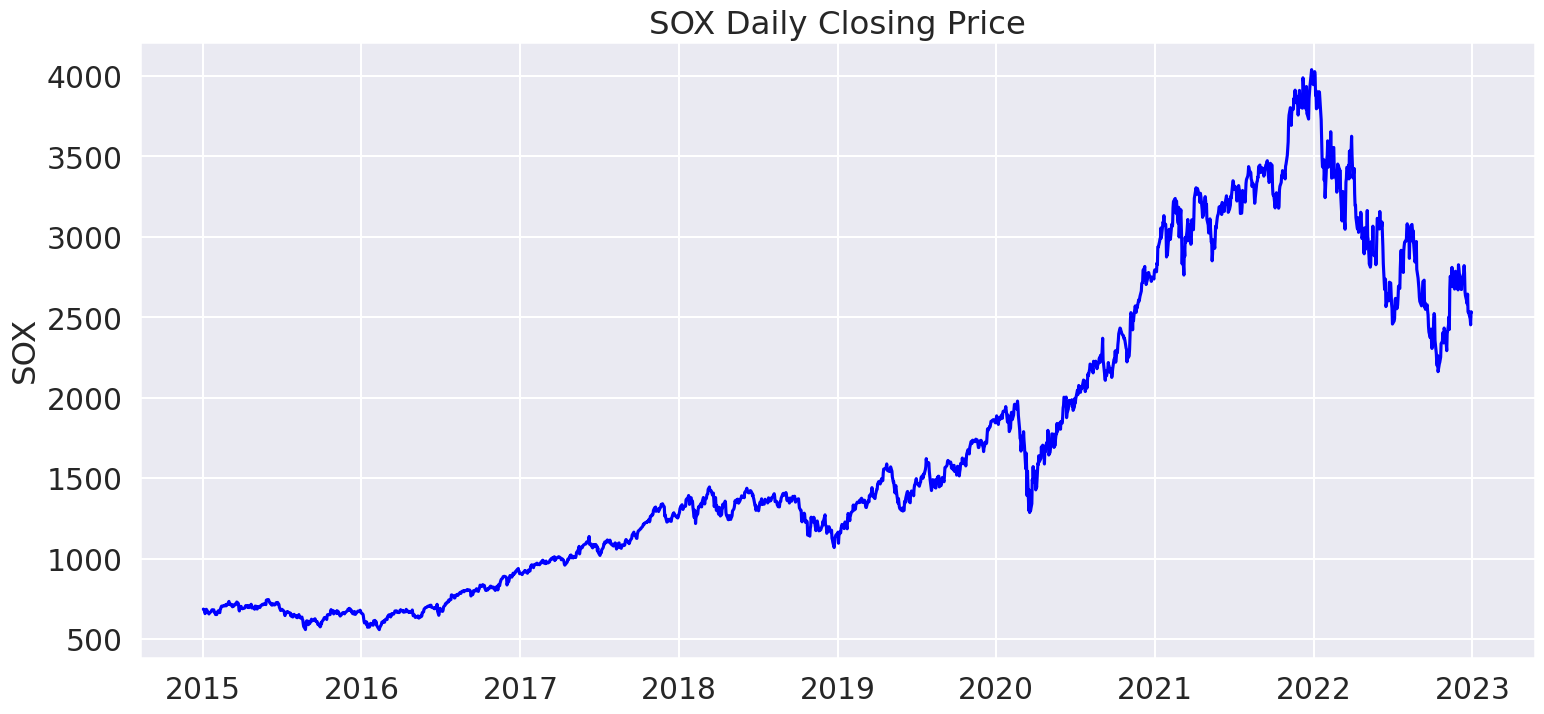

In [26]:
sns.set_context("talk", font_scale=1.3)

# PLOT OUT SOX CLOSING PRICES
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.SOX, color='blue')
    ax.set_title('SOX Daily Closing Price')    

# plt.tight_layout()

In [27]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df.insert(6,'SOX_Returns','')
df['SOX_Returns'] = 100 * df.SOX.pct_change().dropna()

In [28]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df.insert(9,'SOX_Log_Returns','')
df['SOX_Log_Returns'] = np.log(df.SOX/df.SOX.shift(1))

In [29]:
df.insert(6,'SOX_HL_Sprd','')
df['SOX_HL_Sprd'] = (df.High - df.Low) / df.SOX

In [30]:
df.insert(7,'SOX_CO_Sprd','')
df['SOX_CO_Sprd'] = (df.SOX - df.Open) / df.Open

In [31]:
df = df.drop(['Open', 'High', 'Low'], axis=1)

In [32]:
df.head()

SOX        VIX        VIX2  SOX_HL_Sprd  SOX_CO_Sprd  \
2015-01-02  686.729980  17.790001  316.484133     0.020022    -0.005143   
2015-01-05  673.590027  19.920000  396.806403     0.016939    -0.014600   
2015-01-06  658.830017  21.120001  446.054435     0.028490    -0.024129   
2015-01-07  665.270020  19.309999  372.876079     0.014235     0.007344   
2015-01-08  684.650024  17.010000  289.340108     0.021018     0.019113   

            SOX_Returns  VIX_Returns  VIX2_Returns  SOX_Log_Returns  \
2015-01-02          NaN          NaN           NaN              NaN   
2015-01-05    -1.913409    11.973013     25.379557        -0.019320   
2015-01-06    -2.191245     6.024100     12.411098        -0.022156   
2015-01-07     0.977491    -8.570082    -16.405701         0.009727   
2015-01-08     2.913104   -11.910923    -22.403146         0.028715   

            VIX_Log_Returns  VIX2_Log_Returns         BTC  BTC_Returns  \
2015-01-02              NaN               NaN  315.032013     0.249172   
2015-01-05         0.113088          0.226175  274.473999     3.890684   
2015-01-06         0.058496          0.116992  286.188995     4.268163   
2015-01-07        -0.089597         -0.179195  294.337006     2.847073   
2015-01-08        -0.126822         -0.253643  283.348999    -3.733138   

            BTC_Log_Returns  
2015-01-02         0.002489  
2015-01-05         0.038169  
2015-01-06         0.041796  
2015-01-07         0.028073  
2015-01-08        -0.038046

In [33]:
df.describe()

SOX          VIX         VIX2  SOX_HL_Sprd  SOX_CO_Sprd  \
count  2014.000000  2014.000000  2014.000000  2014.000000  2014.000000   
mean   1698.934424    18.775333   414.729334     0.019838     0.000326   
std     946.979979     7.889685   474.188709     0.012280     0.015072   
min     559.179993     9.140000    83.539606     0.000000    -0.094024   
25%     918.062515    13.220000   174.768407     0.011466    -0.007739   
50%    1370.934998    16.660000   277.555595     0.016380     0.000529   
75%    2493.125061    22.477499   505.238002     0.024580     0.008553   
max    4039.510010    82.690002  6837.636504     0.115231     0.076760   

       SOX_Returns  VIX_Returns  VIX2_Returns  SOX_Log_Returns  \
count  2013.000000  2013.000000   2013.000000      2013.000000   
mean      0.084450     0.362162      1.507166         0.000648   
std       1.976862     8.842613     19.954652         0.019829   
min     -15.896286   -25.905673    -45.100307        -0.173119   
25%      -0.898566    -4.612980     -9.013164        -0.009026   
50%       0.147115    -0.746579     -1.487585         0.001470   
75%       1.121150     3.697102      7.530889         0.011149   
max      11.154737   115.597925    364.824653         0.105753   

       VIX_Log_Returns  VIX2_Log_Returns           BTC  BTC_Returns  \
count      2013.000000       2013.000000   2014.000000  2014.000000   
mean          0.000098          0.000196  13333.160124     0.244687   
std           0.082244          0.164487  16319.193602     4.156931   
min          -0.299831         -0.599662    178.102997   -37.169539   
25%          -0.047228         -0.094455    893.271759    -1.442398   
50%          -0.007494         -0.014988   7403.709717     0.192057   
75%           0.036304          0.072608  17547.453613     1.919202   
max           0.768245          1.536490  67566.828125    25.247169   

       BTC_Log_Returns  
count      2014.000000  
mean          0.001571  
std           0.042020  
min          -0.464730  
25%          -0.014529  
50%           0.001919  
75%           0.019010  
max           0.225119

In [34]:
df.dropna(inplace=True)

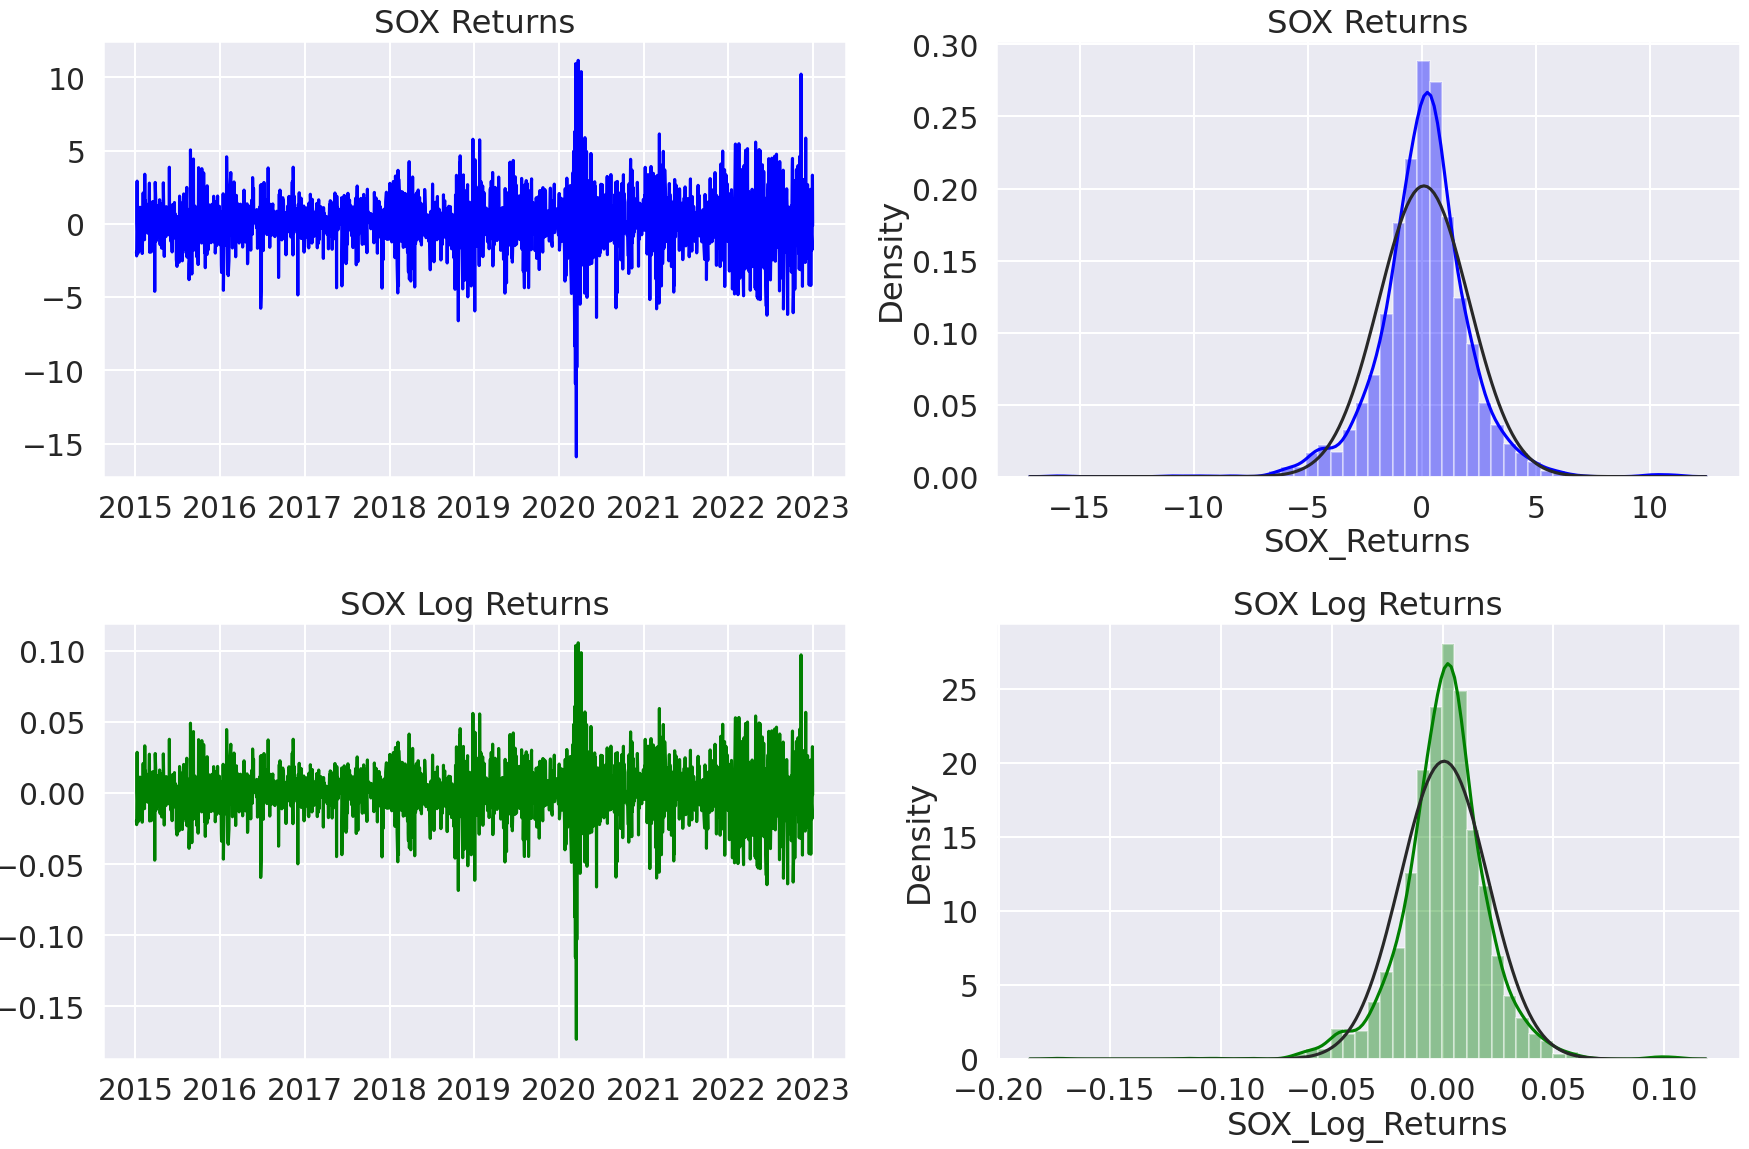

In [35]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.SOX_Returns, color='blue')
    axes[0][0].set_title('SOX Returns')

    sns.distplot(df.SOX_Returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('SOX Returns')

    axes[1][0].plot(df.SOX_Log_Returns, color='green')
    axes[1][0].set_title('SOX Log Returns')

    sns.distplot(df.SOX_Log_Returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('SOX Log Returns')
    plt.tight_layout()
    fig.show()

In [36]:
df.SOX_Returns.describe()

count    2013.000000
mean        0.084450
std         1.976862
min       -15.896286
25%        -0.898566
50%         0.147115
75%         1.121150
max        11.154737
Name: SOX_Returns, dtype: float64

In [37]:
df.SOX_Log_Returns.describe()

count    2013.000000
mean        0.000648
std         0.019829
min        -0.173119
25%        -0.009026
50%         0.001470
75%         0.011149
max         0.105753
Name: SOX_Log_Returns, dtype: float64

In [38]:
# CALCULATE REALIZED VOLATILITY FROM DAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [39]:
# EXPERIMENT WITH DIFFERENT INTERVAL WINDOWS
intervals = [5, 21, 42, 126, 252]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.SOX_Log_Returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

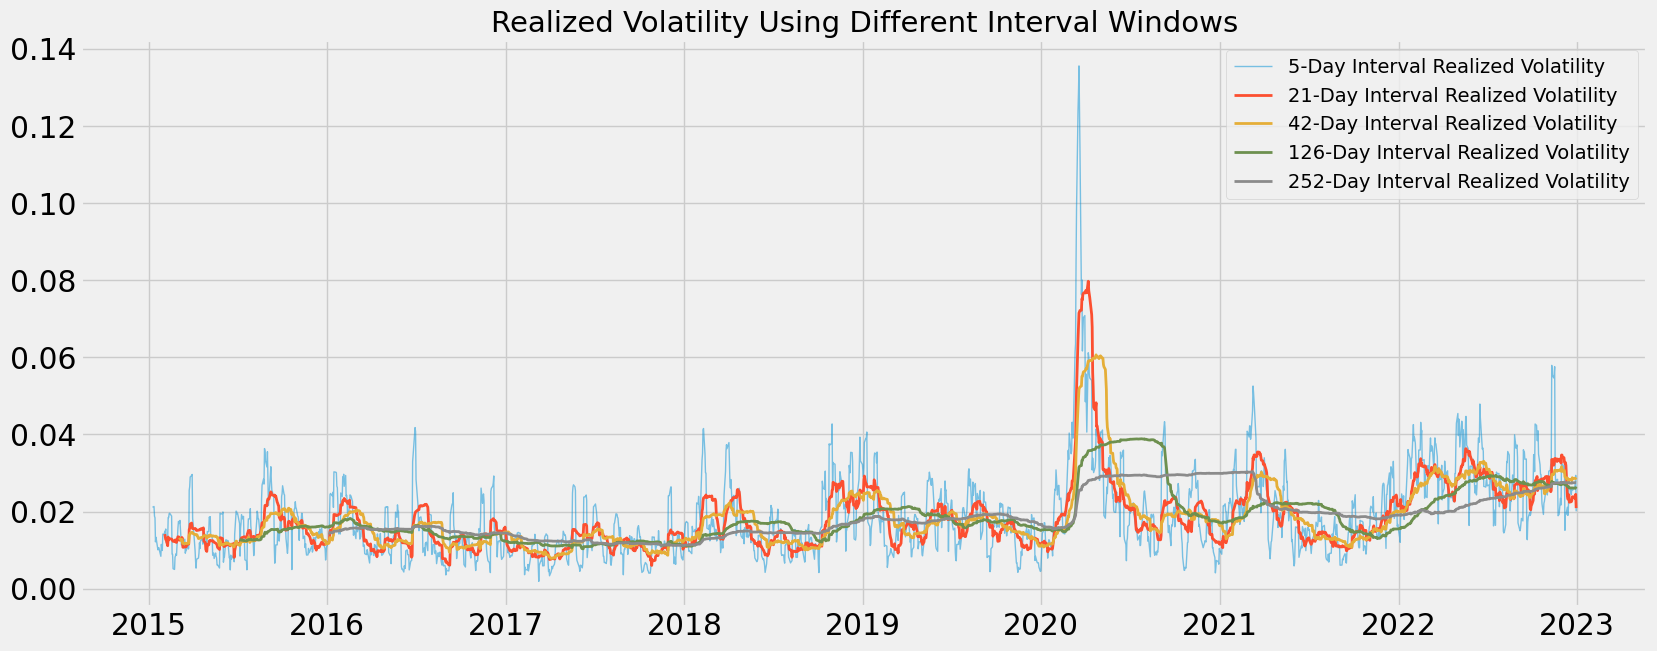

In [40]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 5:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})

plt.show()

In [41]:
INTERVAL_WINDOW = 5
n_future = 5

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['Vol_Current_5d'] = df.SOX_Log_Returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['Vol_Future_5d'] = df.SOX_Log_Returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [42]:
df.describe()

SOX          VIX         VIX2  SOX_HL_Sprd  SOX_CO_Sprd  \
count  2013.000000  2013.000000  2013.000000  2013.000000  2013.000000   
mean   1699.437258    18.775822   414.778139     0.019838     0.000329   
std     946.946311     7.891614   474.301475     0.012283     0.015075   
min     559.179993     9.140000    83.539606     0.000000    -0.094024   
25%     918.159973    13.220000   174.768407     0.011465    -0.007741   
50%    1371.000000    16.660000   277.555595     0.016378     0.000535   
75%    2494.110107    22.480000   505.350379     0.024592     0.008555   
max    4039.510010    82.690002  6837.636504     0.115231     0.076760   

       SOX_Returns  VIX_Returns  VIX2_Returns  SOX_Log_Returns  \
count  2013.000000  2013.000000   2013.000000      2013.000000   
mean      0.084450     0.362162      1.507166         0.000648   
std       1.976862     8.842613     19.954652         0.019829   
min     -15.896286   -25.905673    -45.100307        -0.173119   
25%      -0.898566    -4.612980     -9.013164        -0.009026   
50%       0.147115    -0.746579     -1.487585         0.001470   
75%       1.121150     3.697102      7.530889         0.011149   
max      11.154737   115.597925    364.824653         0.105753   

       VIX_Log_Returns  VIX2_Log_Returns           BTC  BTC_Returns  \
count      2013.000000       2013.000000   2013.000000  2013.000000   
mean          0.000098          0.000196  13339.627153     0.244685   
std           0.082244          0.164487  16320.667002     4.157964   
min          -0.299831         -0.599662    178.102997   -37.169539   
25%          -0.047228         -0.094455    895.026001    -1.442686   
50%          -0.007494         -0.014988   7406.520020     0.191867   
75%           0.036304          0.072608  17586.771484     1.919340   
max           0.768245          1.536490  67566.828125    25.247169   

       BTC_Log_Returns  Vol_Current_5d  Vol_Future_5d  
count      2013.000000     2009.000000    2004.000000  
mean          0.001571        0.018867       0.018868  
std           0.042031        0.011656       0.011669  
min          -0.464730        0.001923       0.001923  
25%          -0.014532        0.011273       0.011263  
50%           0.001917        0.016054       0.016048  
75%           0.019012        0.024314       0.024321  
max           0.225119        0.135543       0.135543

In [43]:
df.dropna(inplace=True)

## **Exploratory Data Analysis**

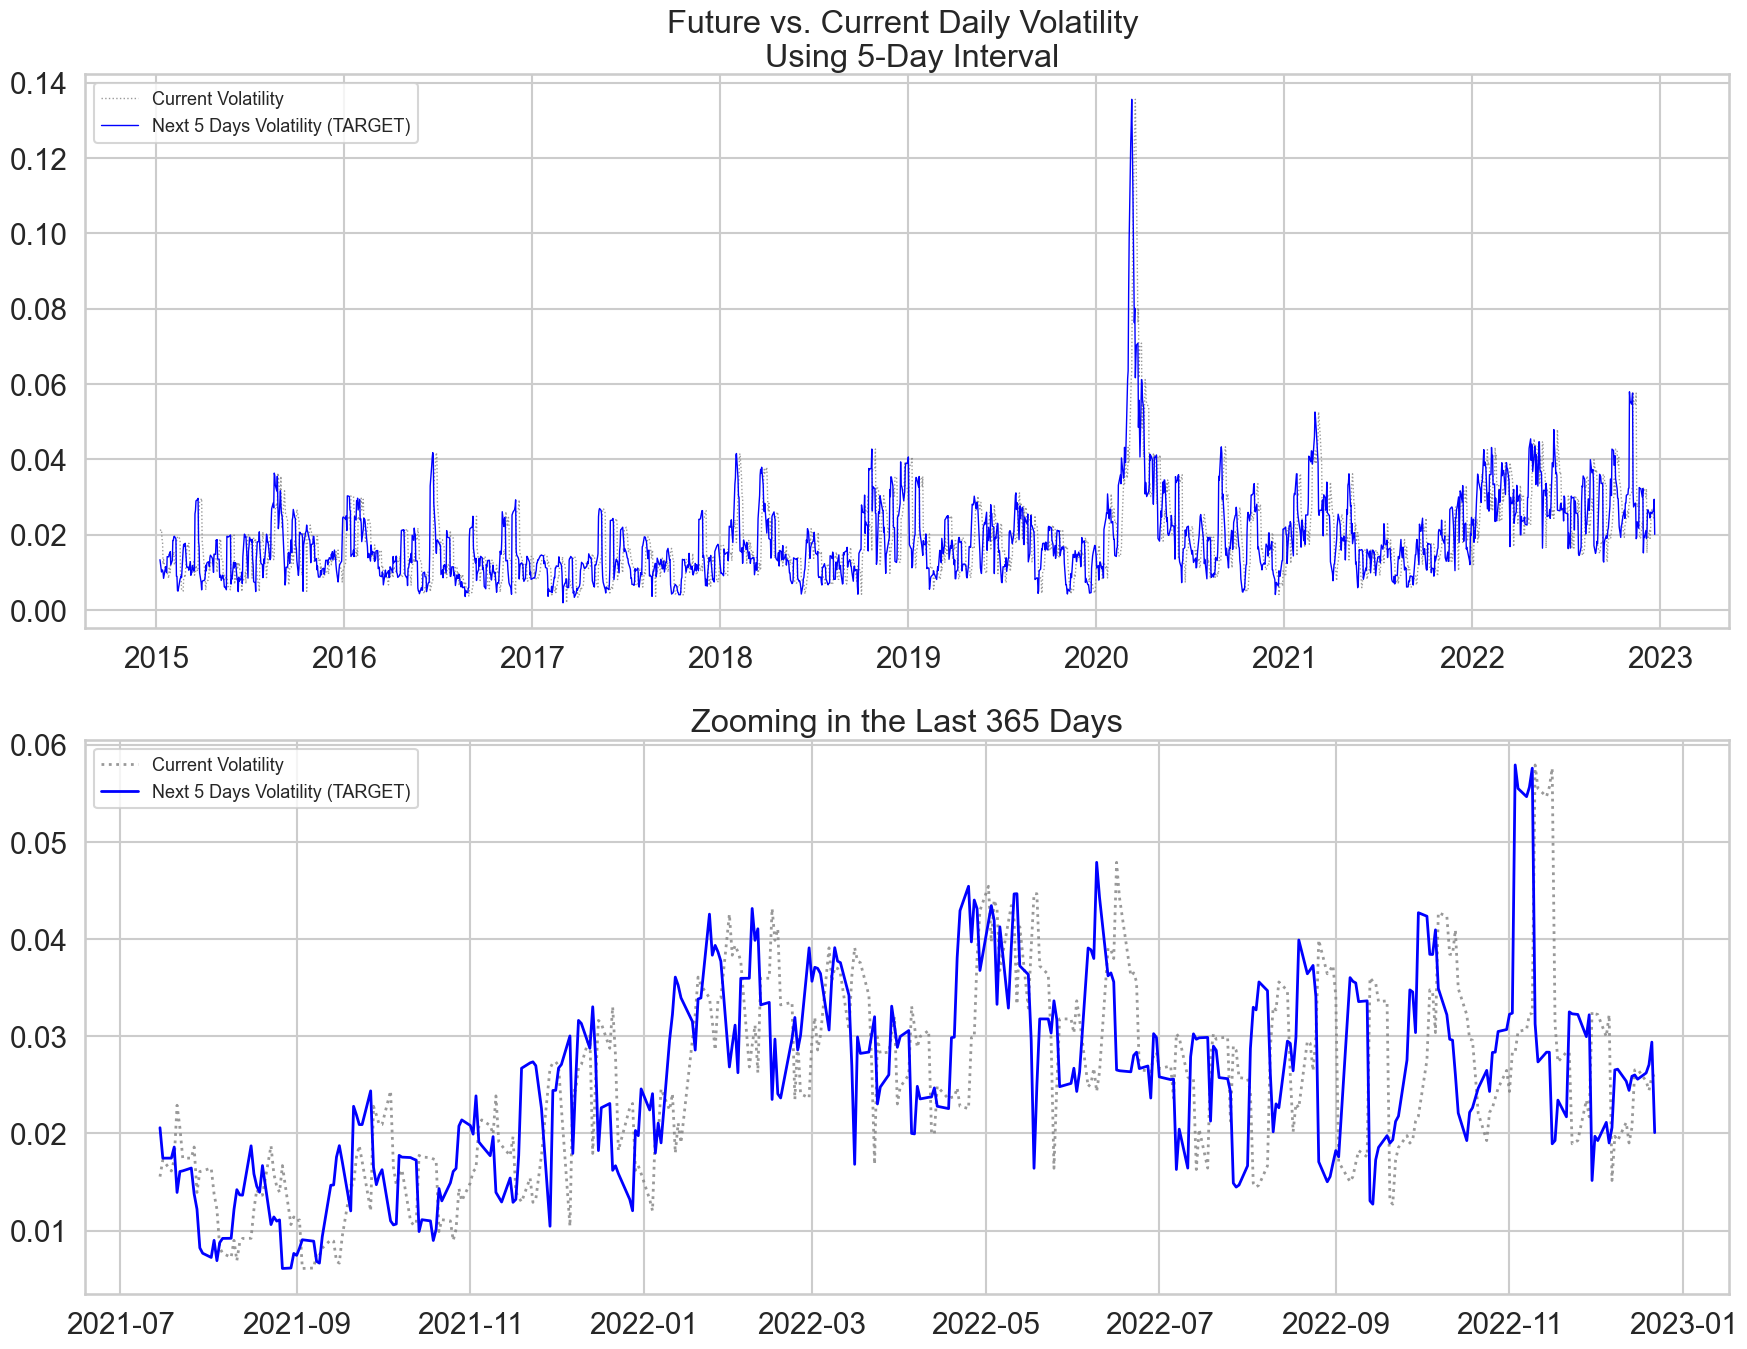

In [44]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.Vol_Current_5d, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.Vol_Future_5d, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.Vol_Current_5d[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.Vol_Future_5d[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()

    plt.show()

### **Daily Volatility Grouped by Month**

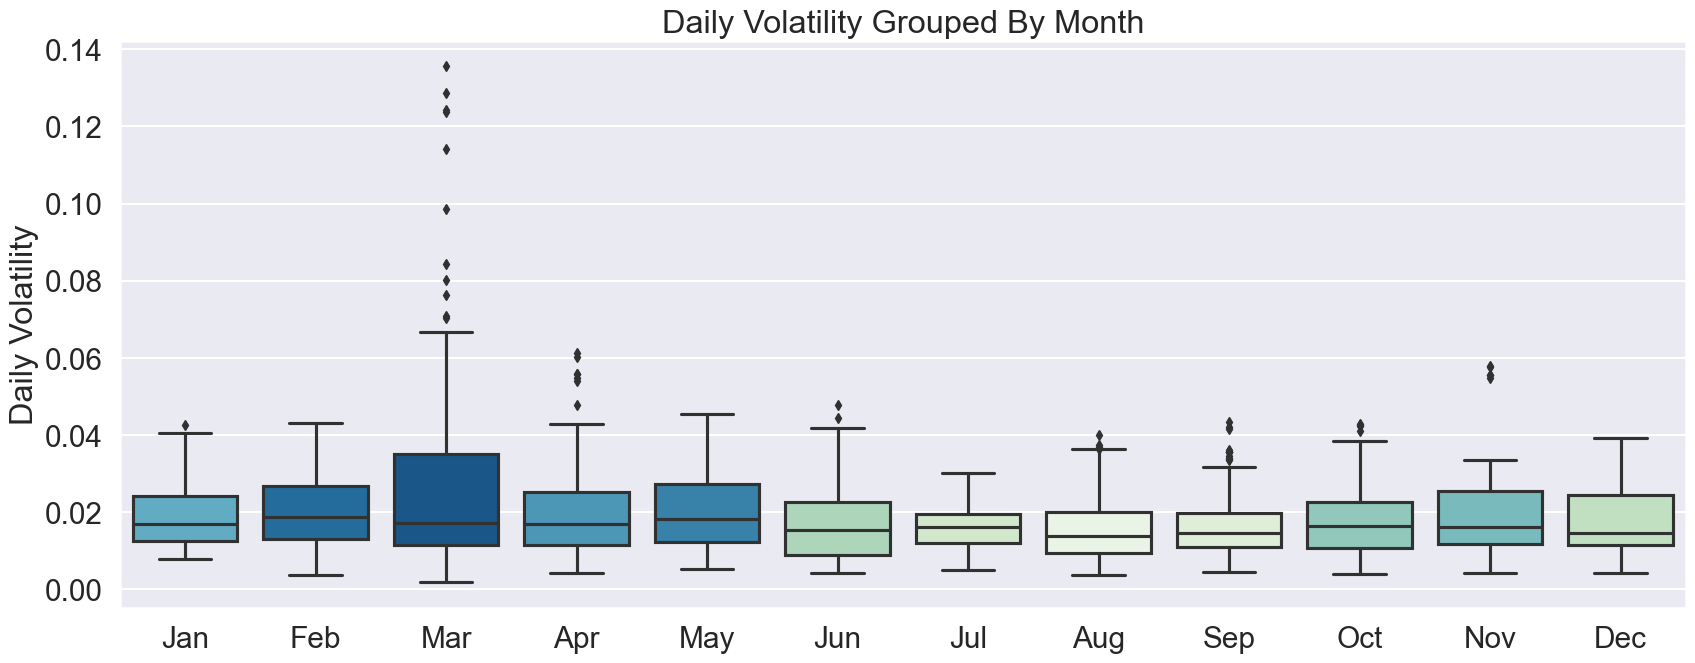

In [45]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER 
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
df.index = pd.to_datetime(df.index)
data = df.groupby(by=[df.index.month_name()]).Vol_Current_5d.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in df.index.month_name()], 
                y=df.Vol_Current_5d, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    plt.show()

In [46]:
df.Vol_Current_5d.sort_values(ascending=False)[:50]

2020-03-18    0.135543
2020-03-17    0.128723
2020-03-19    0.124360
2020-03-16    0.123716
2020-03-20    0.114181
2020-03-13    0.098529
2020-03-12    0.084363
2020-03-24    0.080080
2020-03-23    0.076270
2020-03-30    0.070827
2020-03-27    0.070295
2020-03-26    0.066724
2020-03-11    0.063490
2020-03-25    0.061647
2020-03-10    0.061325
2020-04-06    0.061178
2020-04-07    0.060160
2022-11-10    0.057914
2022-11-16    0.057583
2020-03-09    0.055897
2020-04-08    0.055761
2020-04-01    0.055706
2022-11-15    0.055639
2022-11-11    0.055495
2022-11-14    0.054653
2020-04-09    0.054652
2020-04-13    0.054001
2021-03-09    0.052562
2021-03-10    0.050959
2021-03-11    0.048827
2020-03-31    0.048474
2022-06-16    0.047897
2020-04-02    0.047792
2021-03-12    0.046614
2021-03-08    0.046090
2022-05-02    0.045435
2022-05-19    0.044669
2022-05-18    0.044647
2022-06-17    0.044304
2022-05-04    0.044017
2022-05-10    0.043445
2020-09-09    0.043314
2020-03-04    0.043185
2022-02-15 

### **Daily Volatility Grouped by Year**

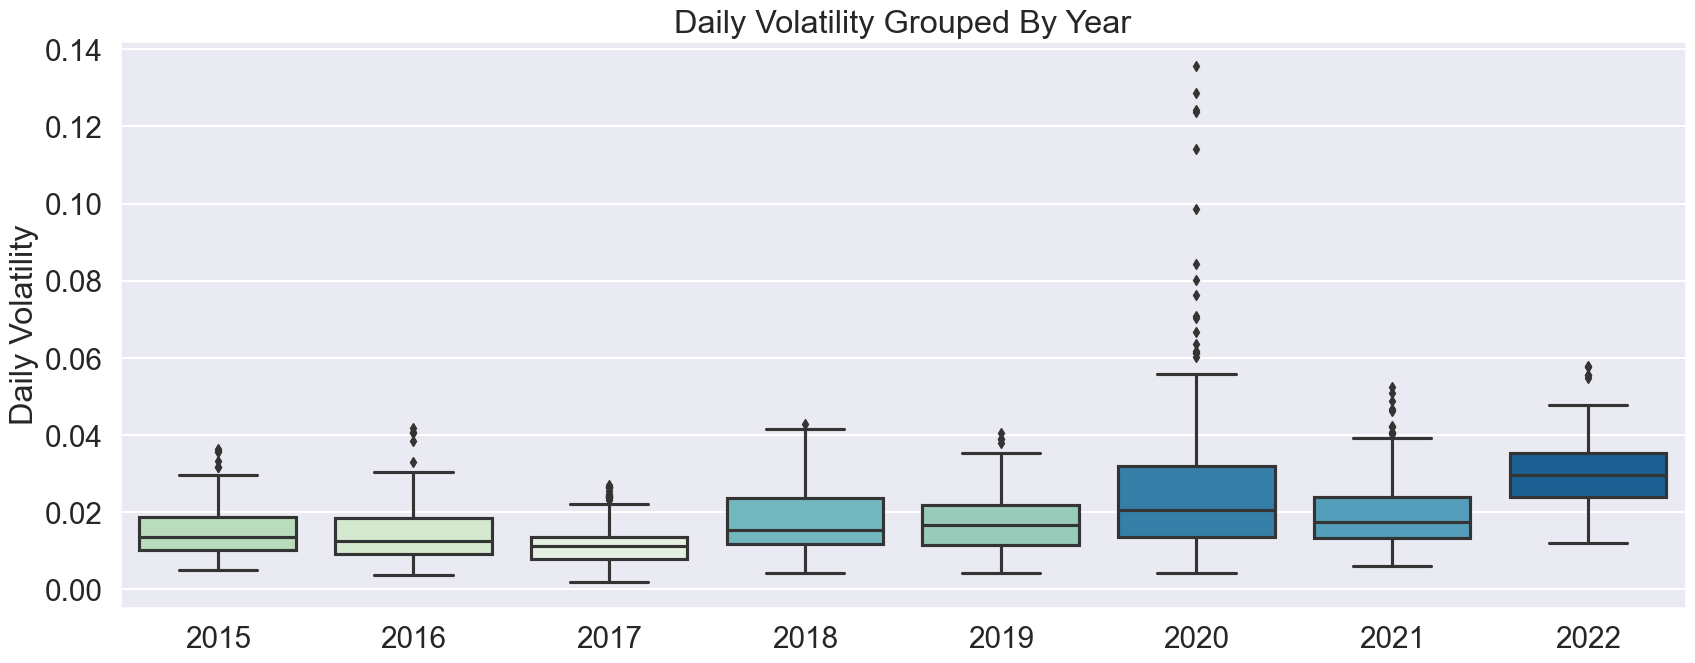

In [47]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).Vol_Current_5d.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=df.index.year, 
                y=df.Vol_Current_5d, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.show()

### **Daily Volatility Distribution**

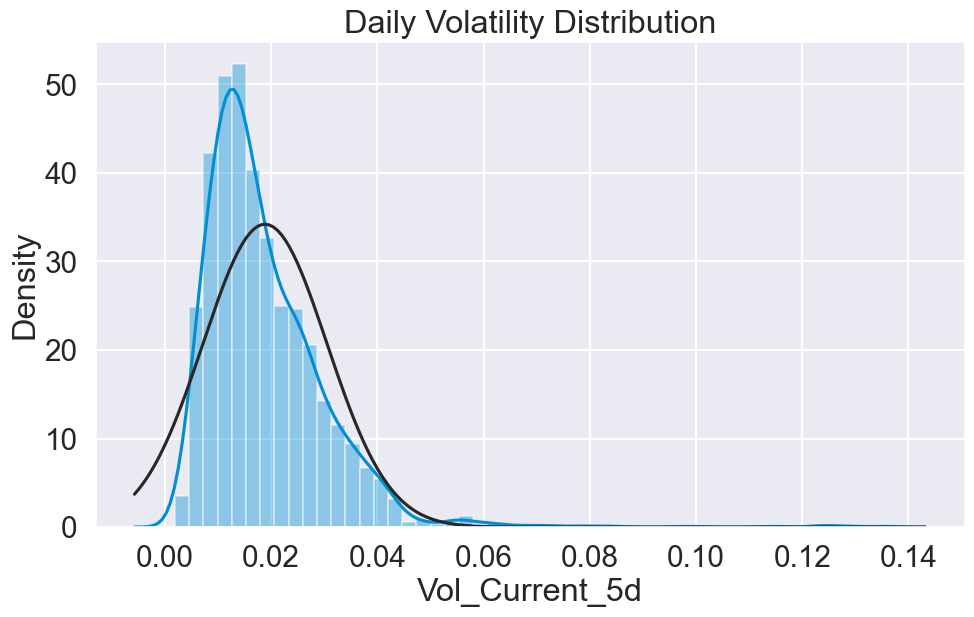

In [48]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.Vol_Current_5d, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.show()

### **Returns/Log Returns Stationarity Checking**



In [49]:
from statsmodels.tsa.stattools import adfuller

In [50]:
# LOG RETURNS
adfuller_results = adfuller(df.SOX_Log_Returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.509826437182086
p-value: 2.3564502296171315e-28
Critical Values:
1%: -3.4336
5%: -2.8630
10%: -2.5675


In [51]:
# RETURNS
adfuller_results = adfuller(df.SOX_Returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.565702594666238
p-value: 2.0161548707733252e-28
Critical Values:
1%: -3.4336
5%: -2.8630
10%: -2.5675


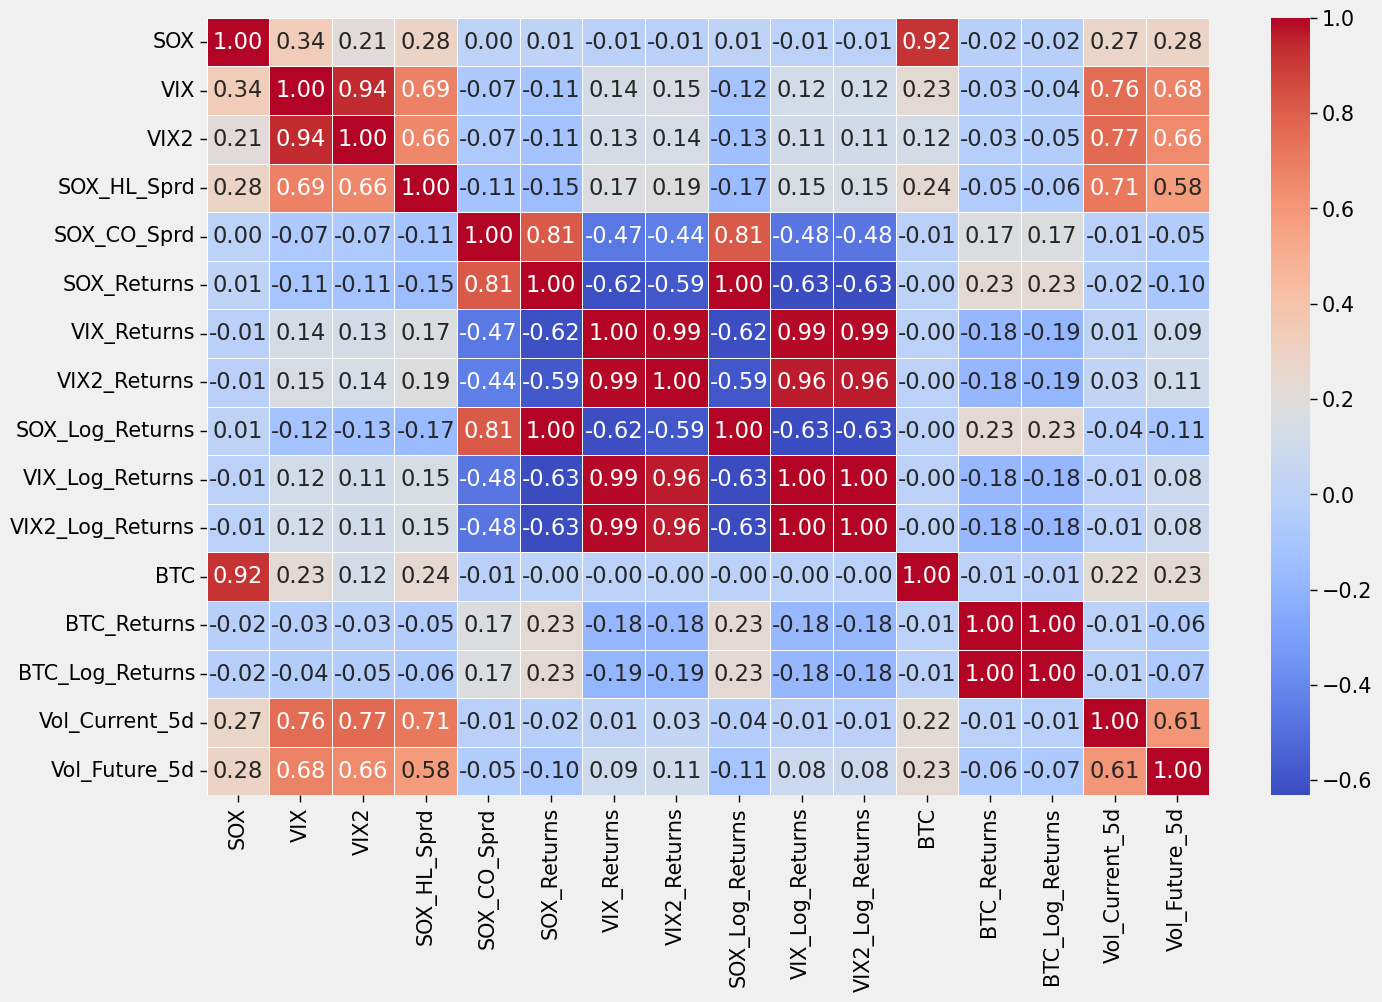

In [157]:
plt.figure(figsize=(14.4, 9.6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
#sns.heatmap(df.corr(), annot=True, cmap='PuBuGn')
plt.show()

## Train-Validation-Test Splits

In [52]:
# TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [53]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2015-01-09 00:00:00 	to: 2021-06-01 00:00:00 	1609 days
VALIDATION 	From: 2021-06-02 00:00:00 	to: 2022-11-09 00:00:00 	365 days
TEST 		From: 2022-11-10 00:00:00 	to: 2022-12-22 00:00:00 	30 days


In [54]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.Vol_Future_5d[train_idx]
y_val = df.Vol_Future_5d[val_idx]
y_test = df.Vol_Future_5d[test_idx]

In [55]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.Vol_Current_5d[train_idx]
x_val = df.Vol_Current_5d[val_idx]
x_test = df.Vol_Current_5d[test_idx]

In [56]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.SOX_Returns[train_idx]
r_val = df.SOX_Returns[val_idx]
r_test = df.SOX_Returns[test_idx]

In [57]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.SOX_Log_Returns[train_idx]
lr_val = df.SOX_Log_Returns[val_idx]
lr_test = df.SOX_Log_Returns[test_idx]

In [58]:
y_train.describe()

count    1609.000000
mean        0.017471
std         0.011614
min         0.001923
25%         0.010575
50%         0.014711
75%         0.021610
max         0.135543
Name: Vol_Future_5d, dtype: float64

In [59]:
x_train.describe()

count    1609.000000
mean        0.017487
std         0.011612
min         0.001923
25%         0.010579
50%         0.014712
75%         0.021610
max         0.135543
Name: Vol_Current_5d, dtype: float64

## Data Preprocessing

### Feature Normalization

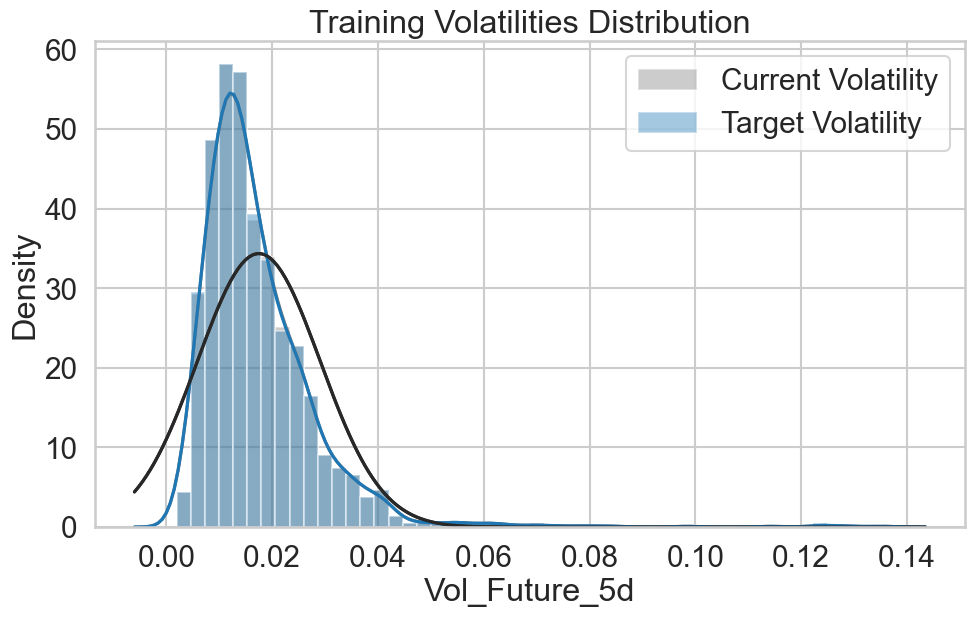

In [60]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.show()

In [61]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [62]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [63]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [64]:
x_train.head(10)

2015-01-09    0.021124
2015-01-12    0.021326
2015-01-13    0.018811
2015-01-14    0.018411
2015-01-15    0.012167
2015-01-16    0.013365
2015-01-20    0.010100
2015-01-21    0.010579
2015-01-22    0.010641
2015-01-23    0.010002
Name: Vol_Current_5d, dtype: float64

In [65]:
y_train.head(10)

2015-01-09    0.013365
2015-01-12    0.010100
2015-01-13    0.010579
2015-01-14    0.010641
2015-01-15    0.010002
2015-01-16    0.008420
2015-01-20    0.011509
2015-01-21    0.010418
2015-01-22    0.009932
2015-01-23    0.014181
Name: Vol_Future_5d, dtype: float64

In [66]:
x_train_scaled.head(10)

2015-01-09    0.143700
2015-01-12    0.145211
2015-01-13    0.126388
2015-01-14    0.123394
2015-01-15    0.076664
2015-01-16    0.085629
2015-01-20    0.061199
2015-01-21    0.064782
2015-01-22    0.065245
2015-01-23    0.060467
dtype: float64

In [67]:
y_train_scaled.head(10)

2015-01-09    0.085629
2015-01-12    0.061199
2015-01-13    0.064782
2015-01-14    0.065245
2015-01-15    0.060467
2015-01-16    0.048627
2015-01-20    0.071741
2015-01-21    0.063579
2015-01-22    0.059936
2015-01-23    0.091737
dtype: float64

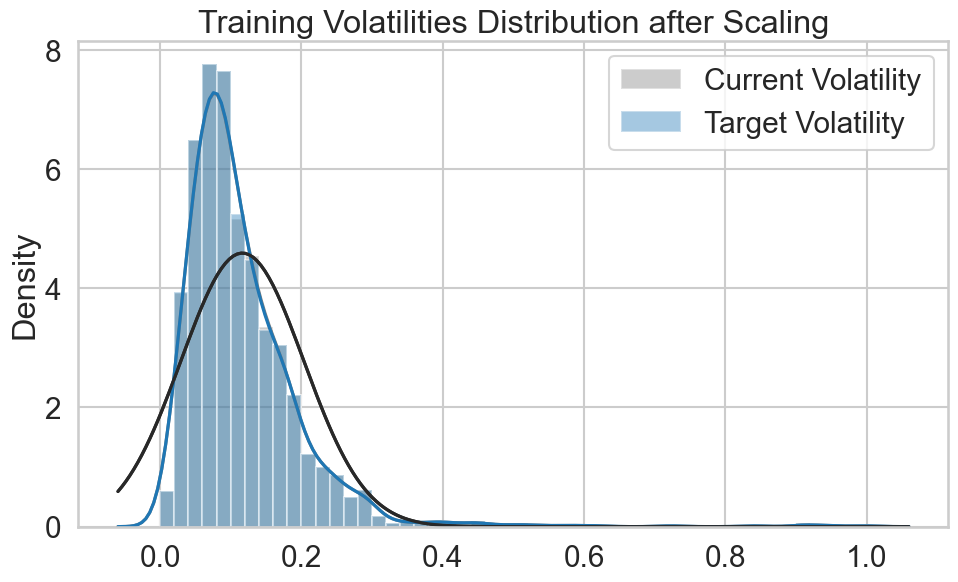

In [68]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show()

### Train-Validation-Test Visualization

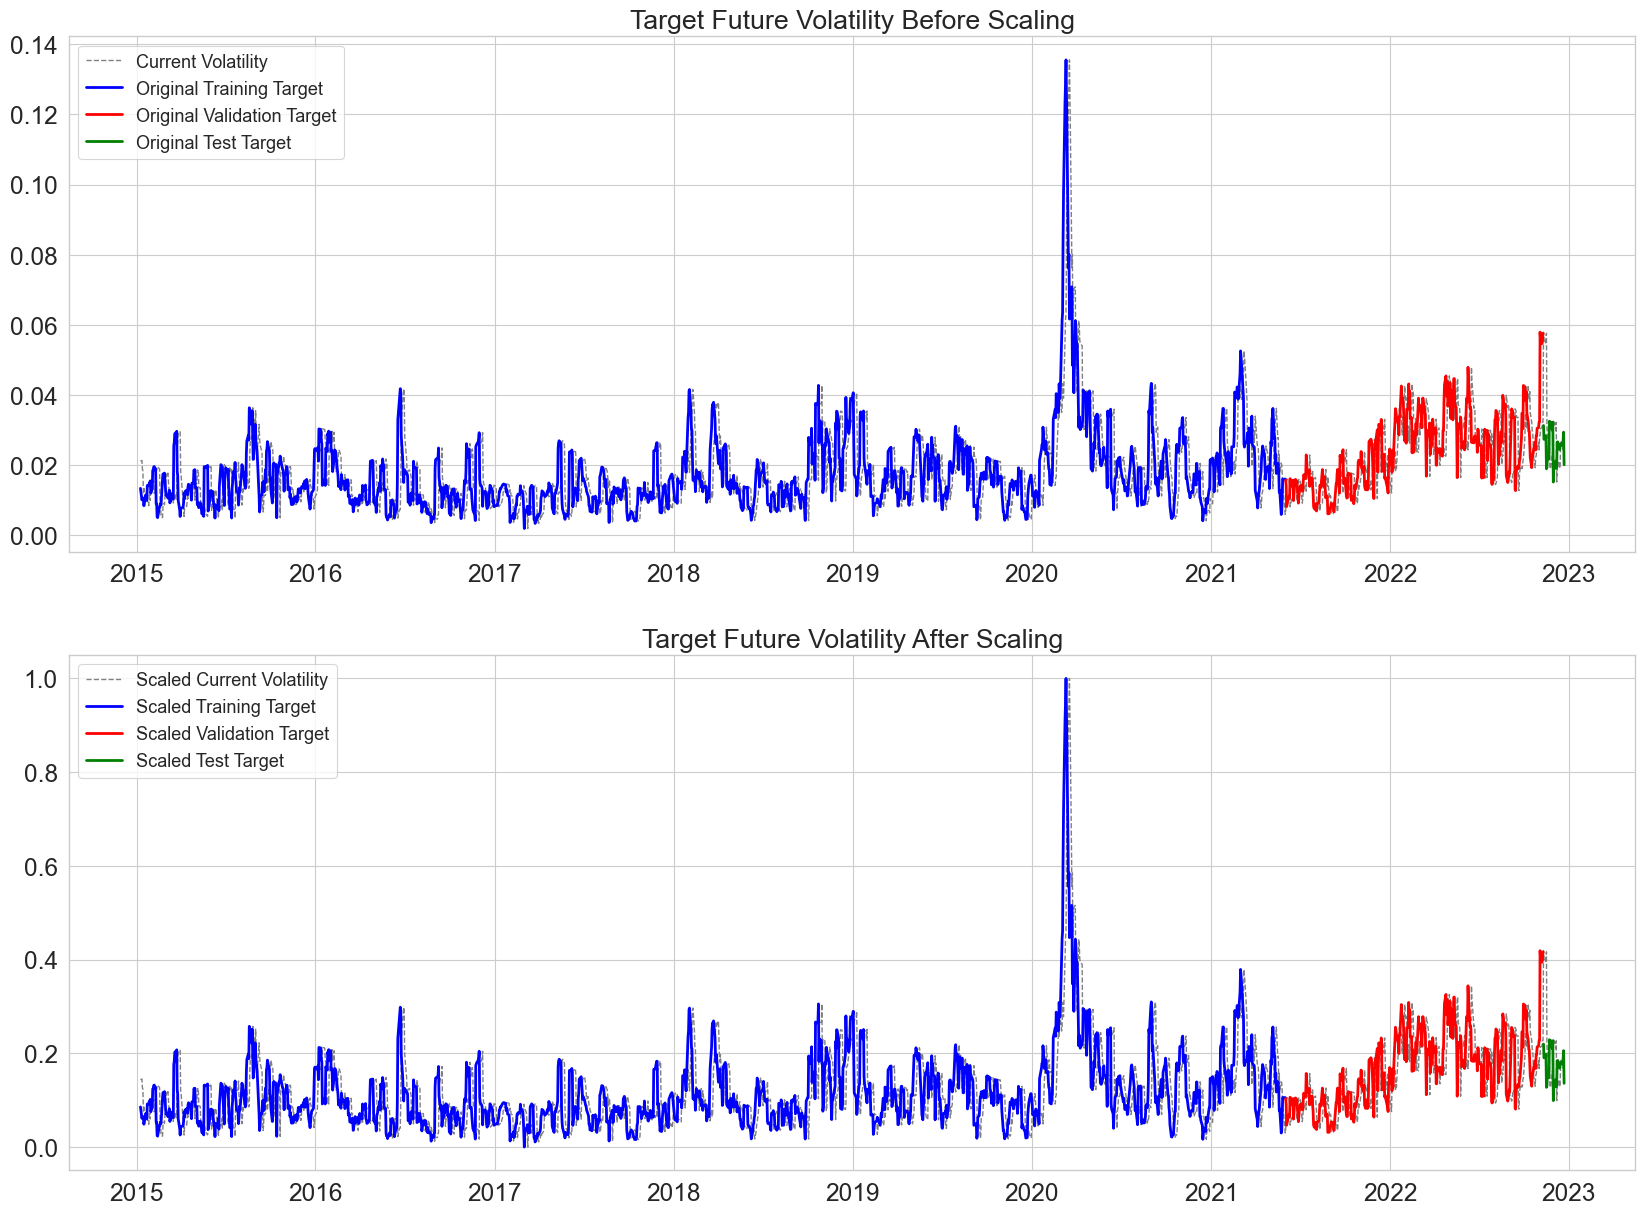

In [69]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.Vol_Current_5d, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='red', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.Vol_Current_5d), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='red', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show()

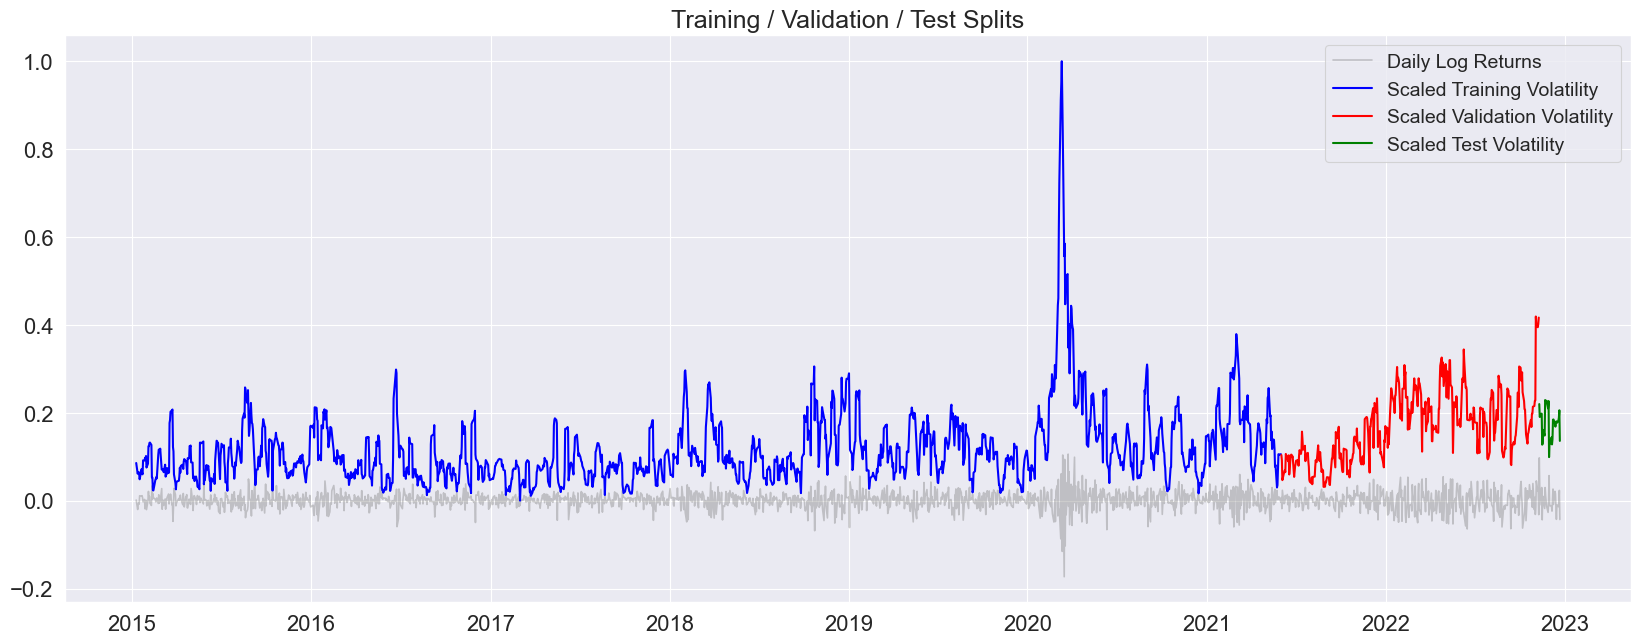

In [70]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.SOX_Log_Returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=18)
    plt.legend(prop={'size': 14}, frameon=True)
    plt.show()

# Modeling

## 1. Performance Metrics

The three main metrics we will using are **RMSPE (Root Mean Squared Percentage Error)**, **RMSE (Root Mean Square Errors)** and **R2 (R-squared)**.
RMSE, RMSPE and R2 would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [71]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [72]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [73]:
# DEFINE R-SQUARED FUNCTION
def R_Squared(y_true, y_pred):
    """
    Compute R-squared between 2 arrays
    """
    output = r2(y_true, y_pred)
    return output

In [74]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE', 'Validation R2'])

In [75]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE, RMPSE and R2 INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred),
                                       R_Squared(y_true, y_pred)]
    return perf_df

In [76]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

# 2. Baseline Models
## 2.1 Mean Baseline

In [77]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.11648242205827365

In [78]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

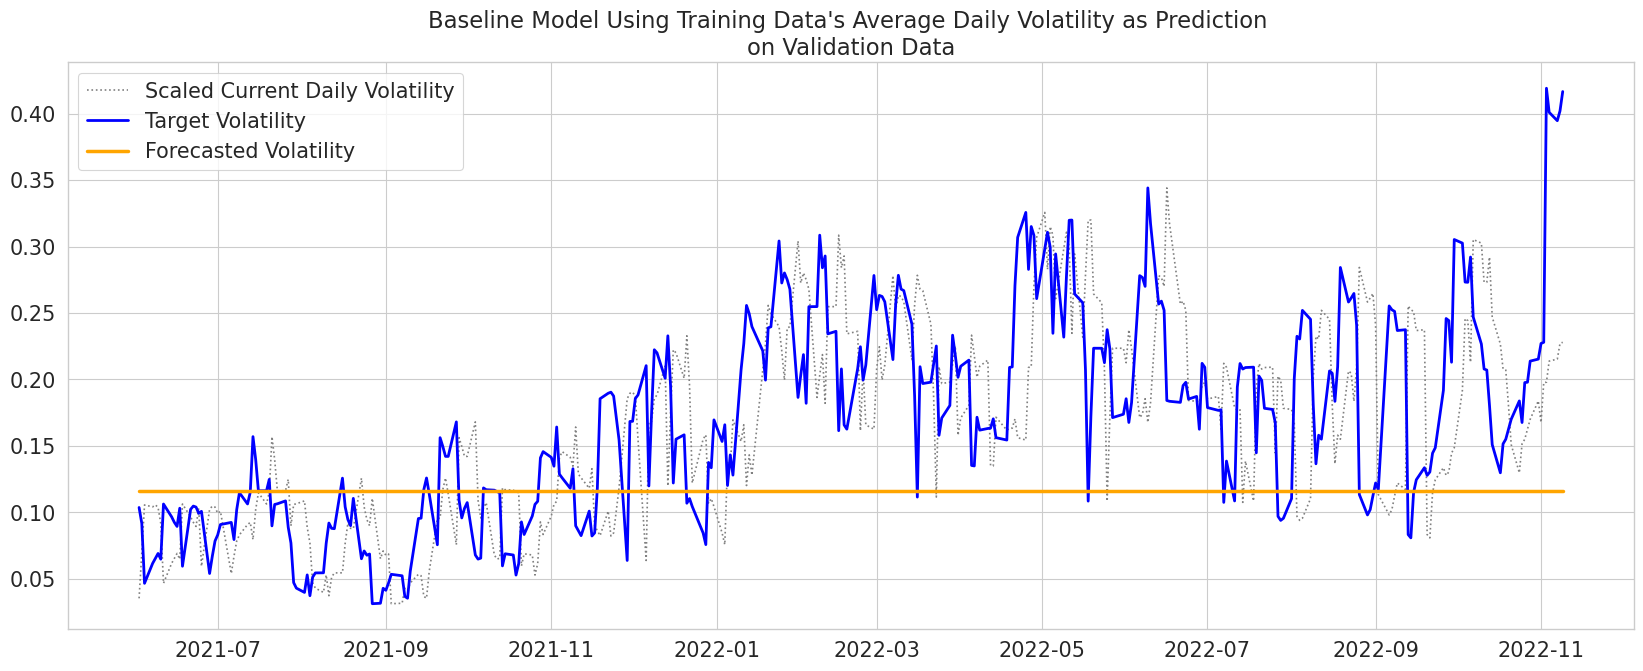

In [79]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.show()

In [80]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE  Validation R2
0  Mean Baseline           0.58046          0.09369      -0.458183

## 2.2 Random Walk Naive Forecasting

In [81]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

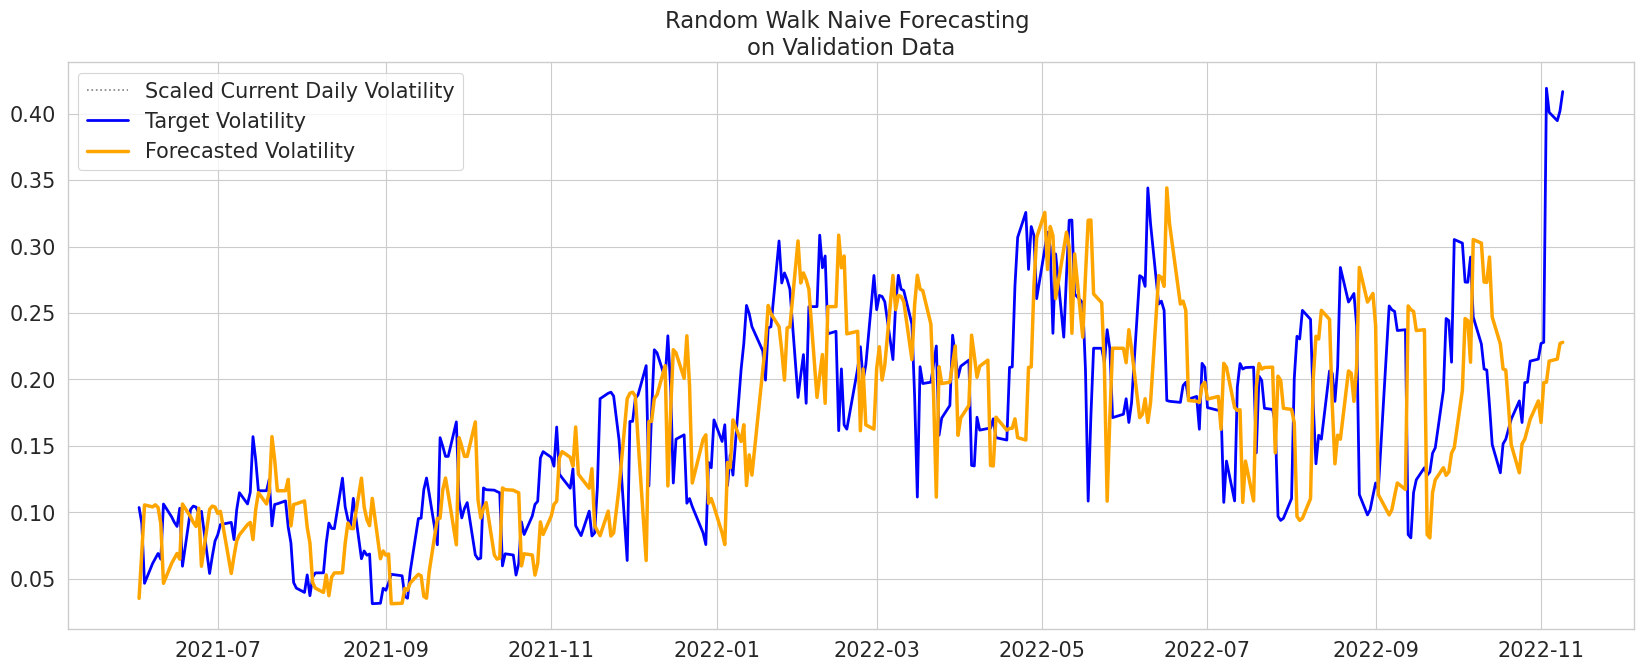

In [82]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.show()

In [83]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE  \
0                  Mean Baseline          0.580460          0.09369   
1  Random Walk Naive Forecasting          0.544265          0.07232   

   Validation R2  
0      -0.458183  
1       0.131171

# 3. GARCH Models

## 3.1 Basic GARCH

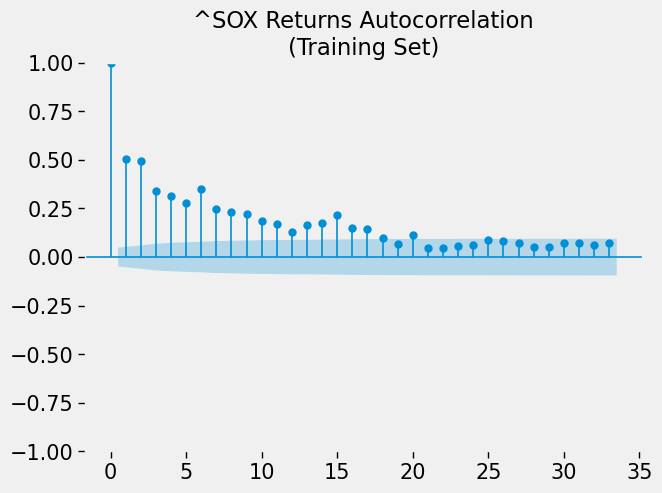

In [84]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr_SOX.upper()} Returns Autocorrelation\n(Training Set)');

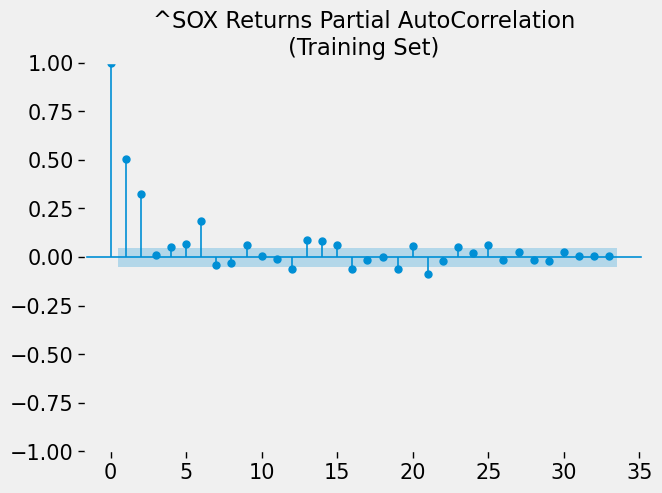

In [85]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr_SOX.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [86]:
from arch import arch_model

In [87]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            SOX_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3037.00
Distribution:                  Normal   AIC:                           6106.01
Method:            Maximum Likelihood   BIC:                           6192.14
                                        No. Observations:                 1609
Date:                Wed, Apr 24 2024   Df Residuals:                     1608
Time:                        17:43:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1196  3.796e-02      3.149  1.638e-03 [4.514e-

In [88]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            SOX_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3040.64
Distribution:                  Normal   AIC:                           6089.29
Method:            Maximum Likelihood   BIC:                           6110.82
                                        No. Observations:                 1609
Date:                Wed, Apr 24 2024   Df Residuals:                     1608
Time:                        17:43:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1235  3.708e-02      3.332  8.625e-04 [5.087e-

In [89]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [90]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [91]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show()

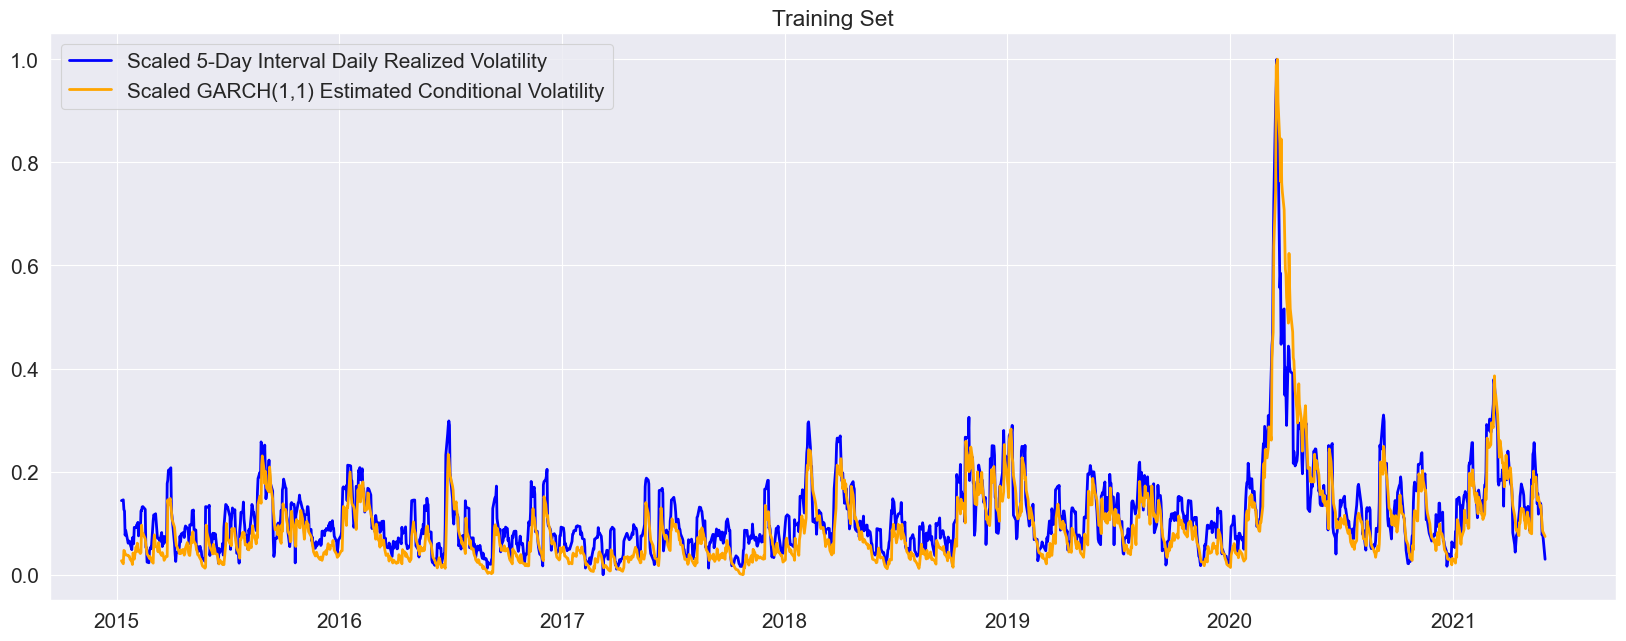

In [92]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

In [93]:
# ONE STEP EXPANDING WINDOW FORECAST
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [94]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

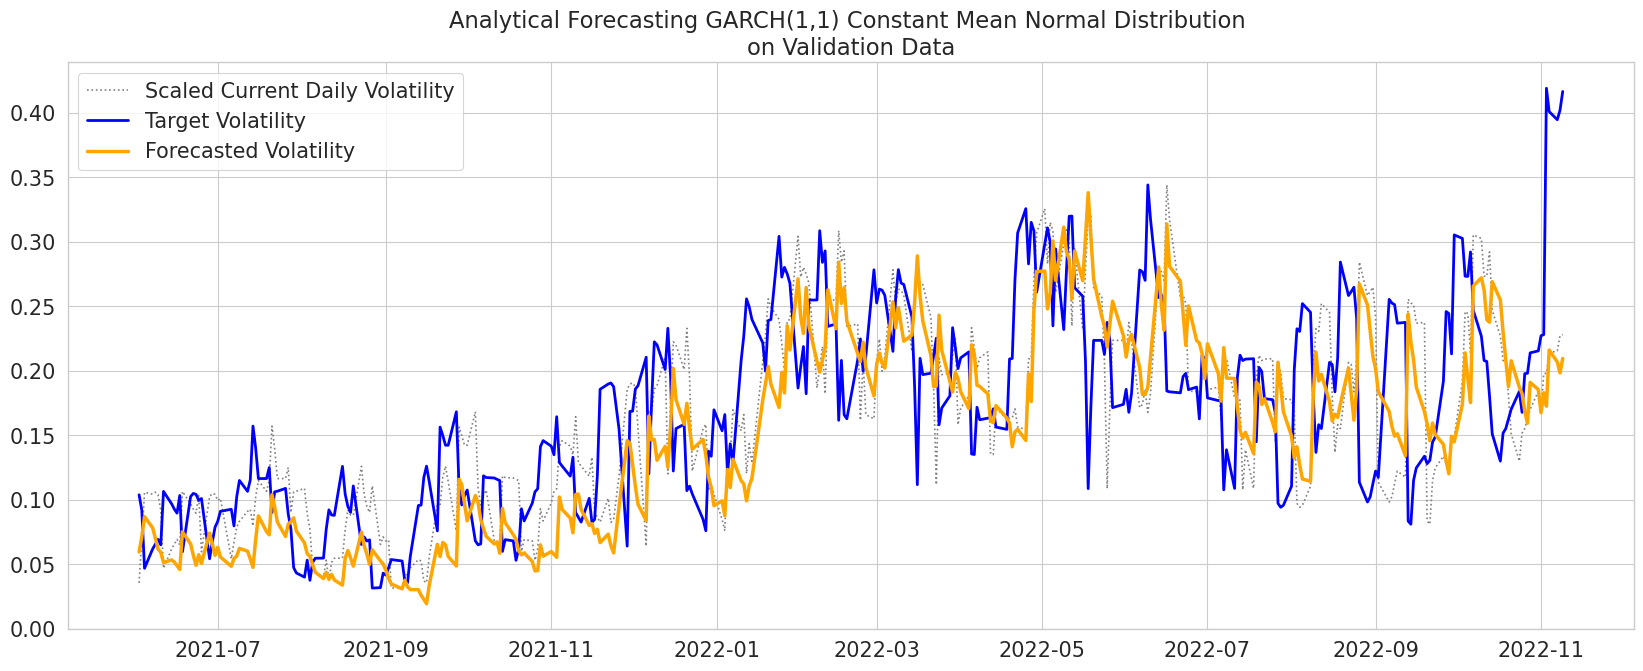

In [95]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [96]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE  \
0                           Mean Baseline          0.580460         0.093690   
1           Random Walk Naive Forecasting          0.544265         0.072320   
2  GARCH(1,1), Constant Mean, Normal Dist          0.461228         0.070464   

   Validation R2  
0      -0.458183  
1       0.131171  
2       0.175174

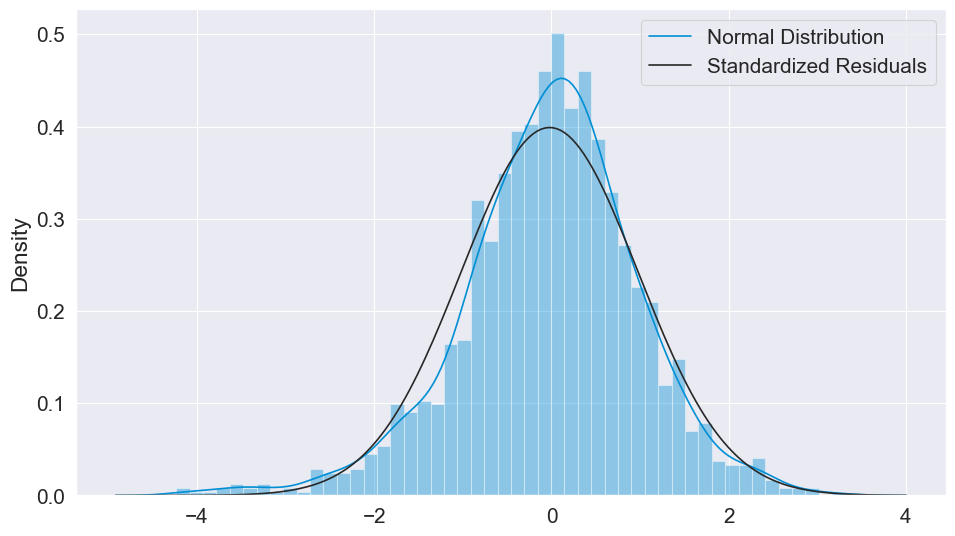

In [97]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show()

## 3.2 GARCH Model with Asymmetric Shocks Responses

In [98]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                       SOX_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2991.22
Distribution:      Standardized Skew Student's t   AIC:                           5996.44
Method:                       Maximum Likelihood   BIC:                           6034.12
                                                   No. Observations:                 1609
Date:                           Wed, Apr 24 2024   Df Residuals:                     1608
Time:                                   17:43:37   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

In [99]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

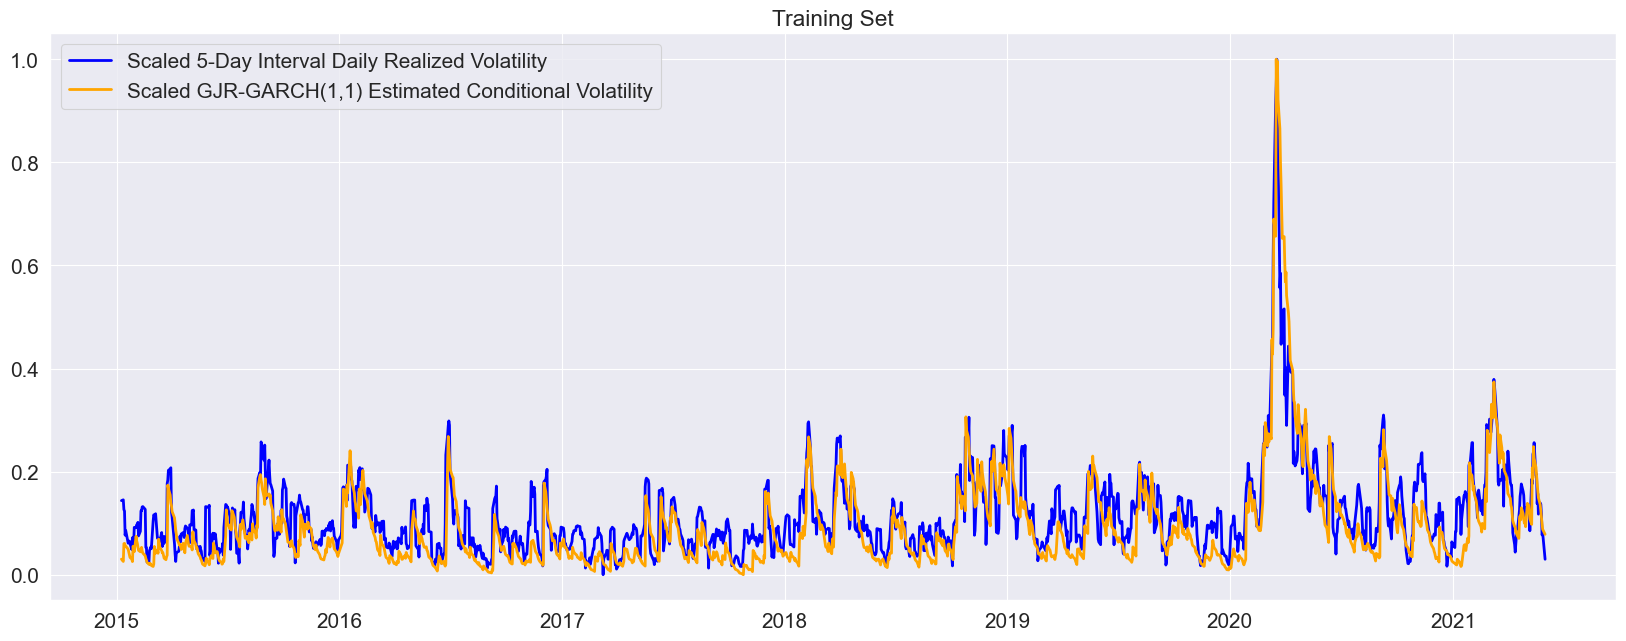

In [100]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [101]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [102]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

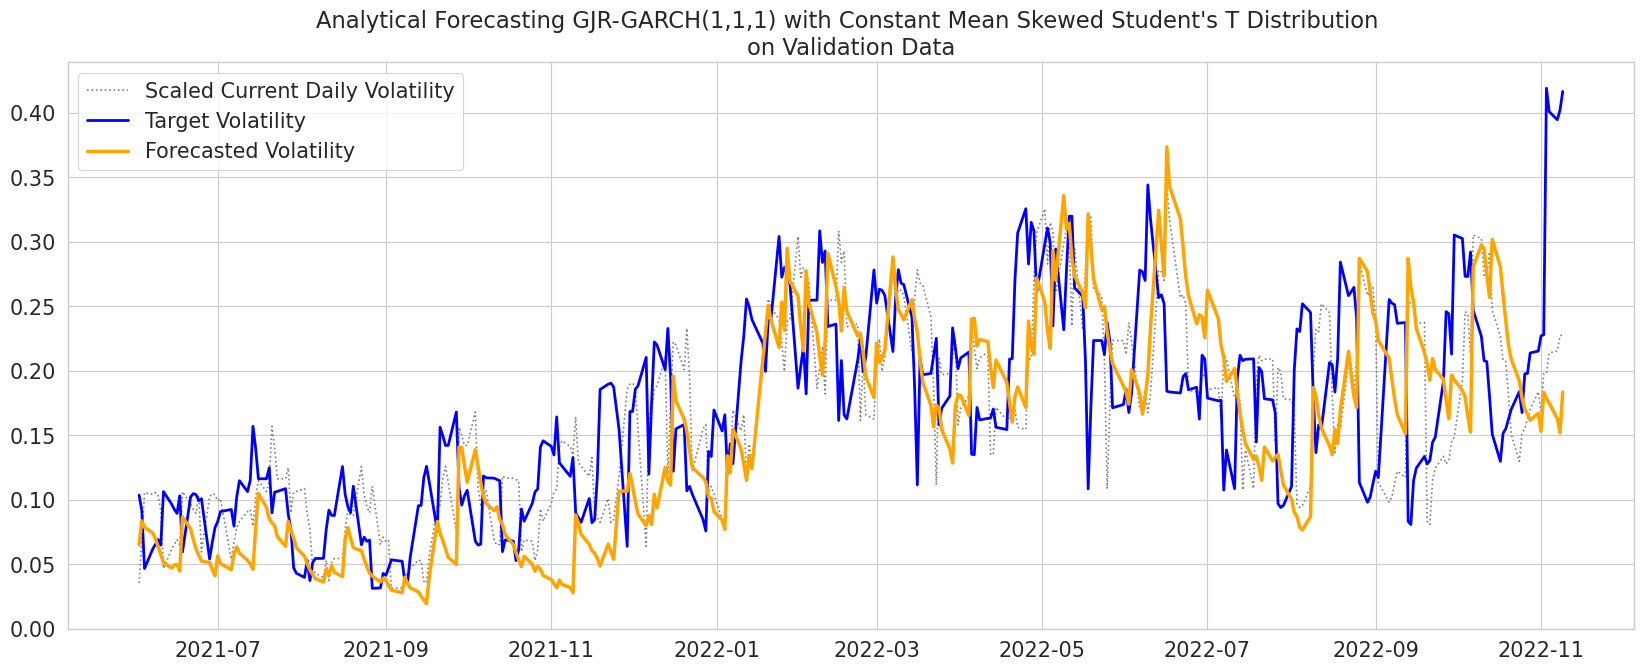

In [103]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [104]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.580460   
1                           Random Walk Naive Forecasting          0.544265   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.461228   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.489346   

   Validation RMSE  Validation R2  
0         0.093690      -0.458183  
1         0.072320       0.131171  
2         0.070464       0.175174  
3         0.075493       0.053246

## 3.3 TARCH

In [105]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                       SOX_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -2981.04
Distribution:      Standardized Skew Student's t   AIC:                           5976.08
Method:                       Maximum Likelihood   BIC:                           6013.76
                                                   No. Observations:                 1609
Date:                           Wed, Apr 24 2024   Df Residuals:                     1608
Time:                                   17:44:09   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

In [106]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

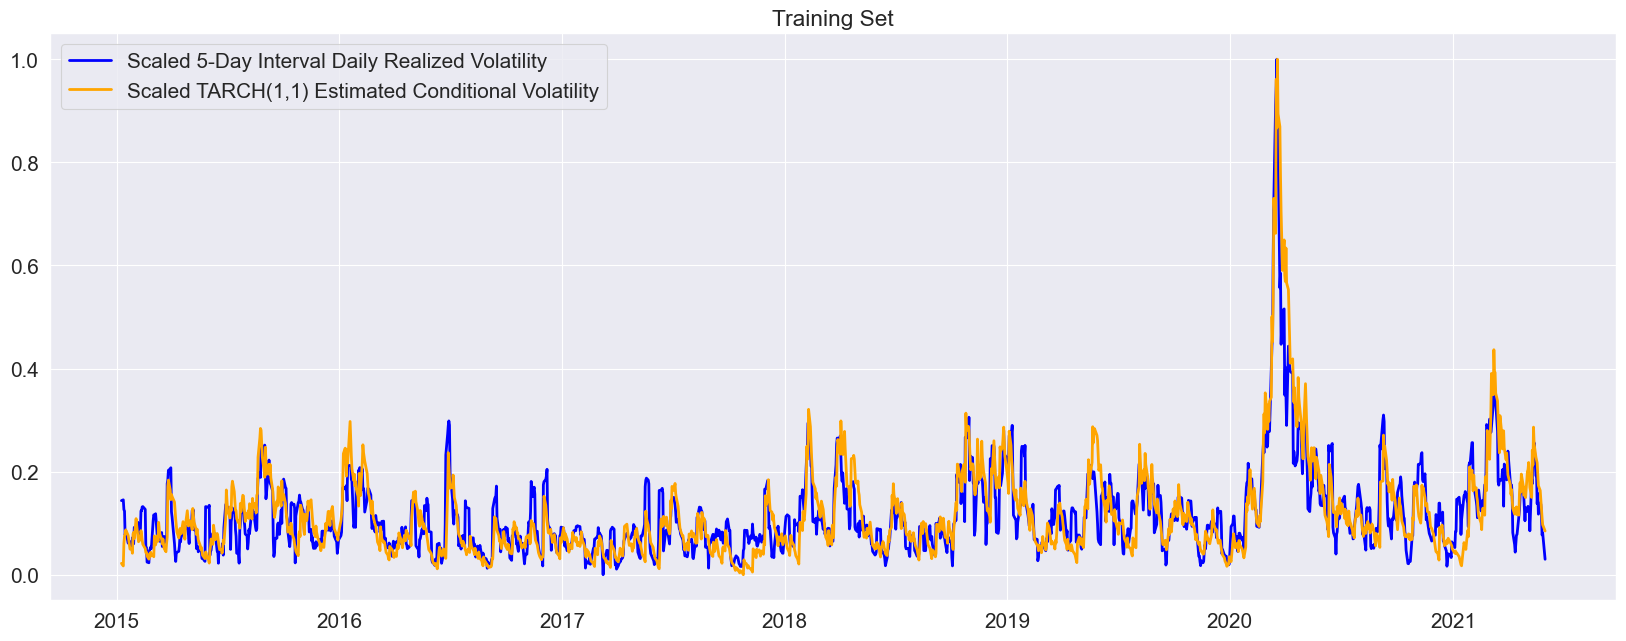

In [107]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

### 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)

In [108]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [109]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

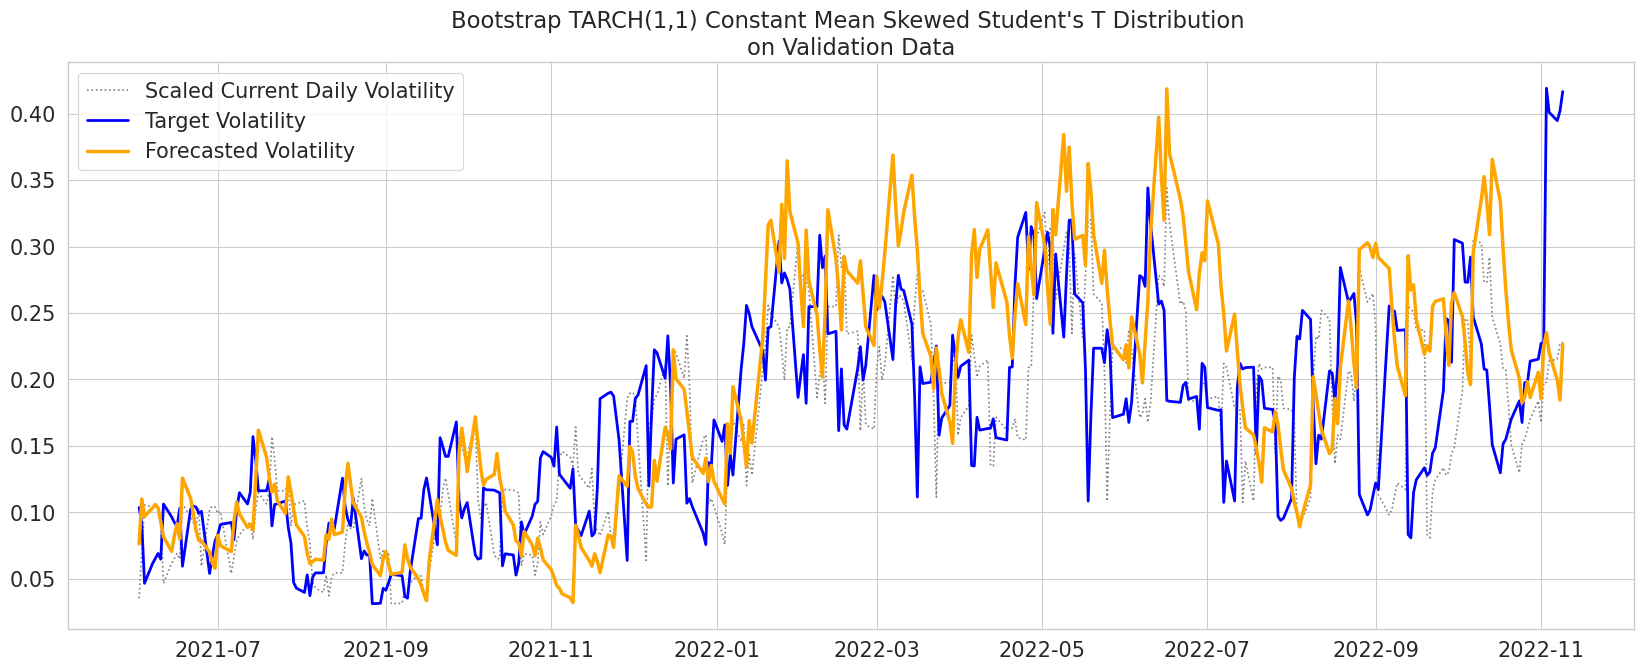

In [110]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [111]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.580460   
1                           Random Walk Naive Forecasting          0.544265   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.461228   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.489346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.573575   

   Validation RMSE  Validation R2  
0         0.093690      -0.458183  
1         0.072320       0.131171  
2         0.070464       0.175174  
3         0.075493       0.053246  
4         0.079306      -0.044808

### 3.3.2 Simulation-based Forecasting for TARCH(1,1)

In [112]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [113]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

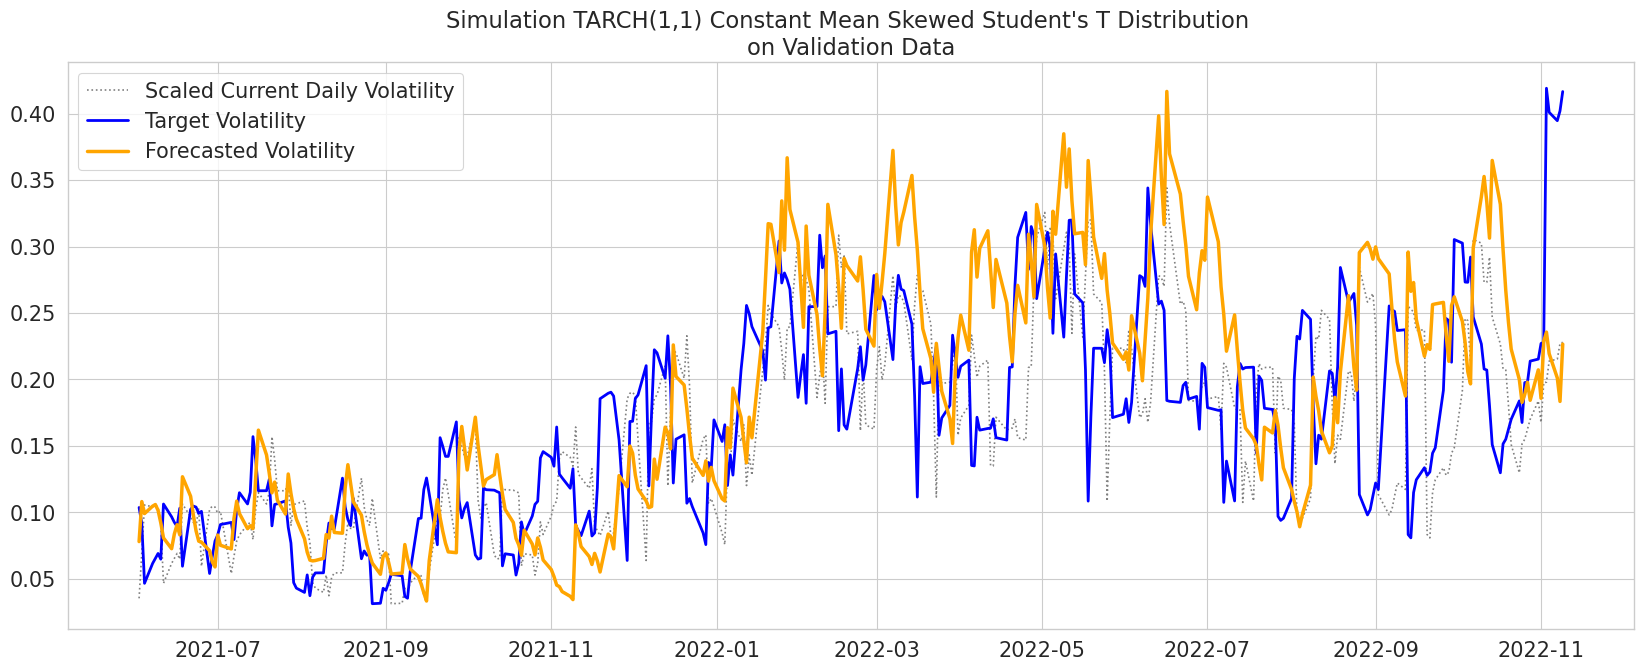

In [114]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [115]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.580460   
1                           Random Walk Naive Forecasting          0.544265   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.461228   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.489346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.573575   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.574685   

   Validation RMSE  Validation R2  
0         0.093690      -0.458183  
1         0.072320       0.131171  
2         0.070464       0.175174  
3         0.075493       0.053246  
4         0.079306      -0.044808  
5         0.079331      -0.045455

### 3.3.3. Hyperparameter Tuning for TARCH

In [116]:
import itertools

In [117]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.SOX_Returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [118]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.47586242429872716 using TARCH(2, 0, 1)


In [119]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

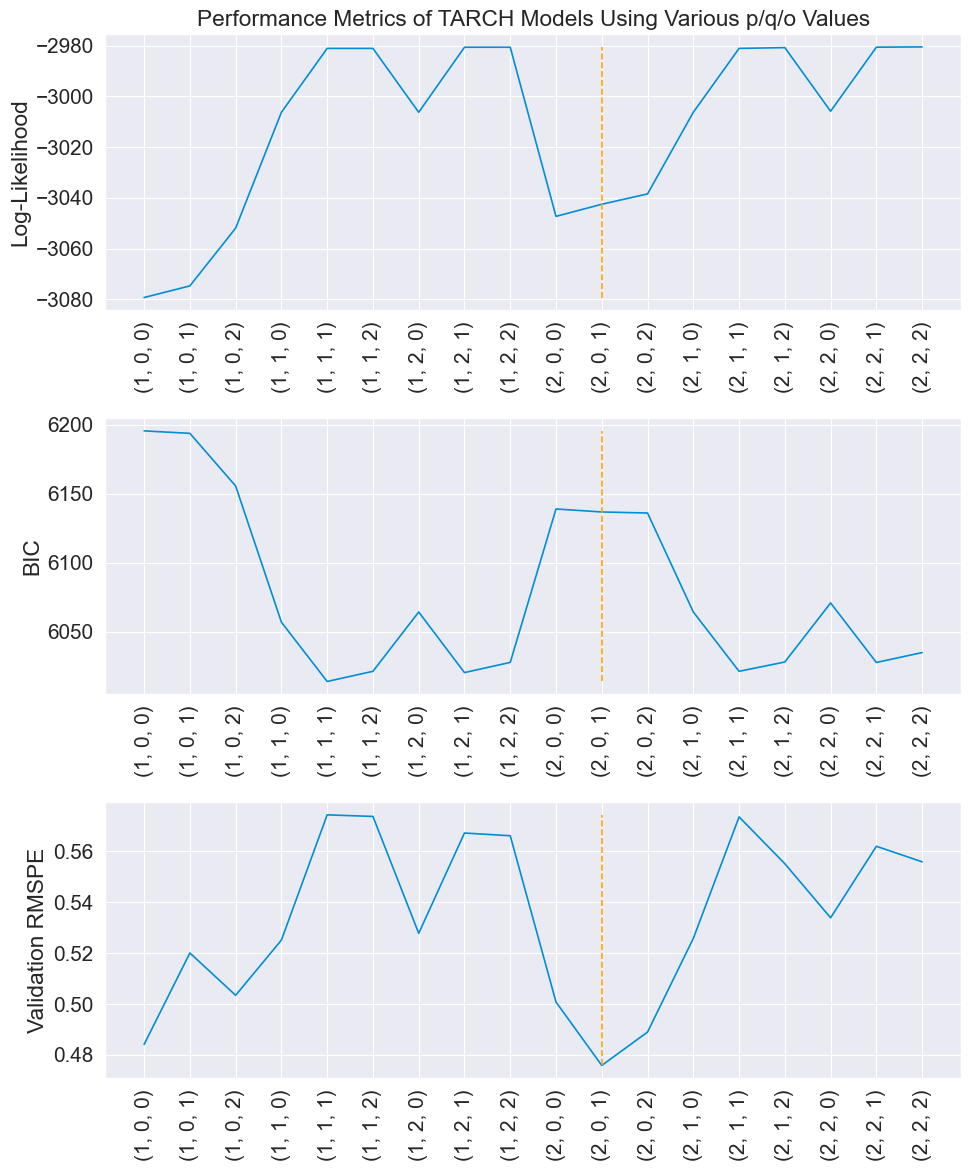

In [120]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();    

### 3.4. Final GARCH Model - TARCH(1,2)

In [121]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                       SOX_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -3042.54
Distribution:      Standardized Skew Student's t   AIC:                           6099.08
Method:                       Maximum Likelihood   BIC:                           6136.76
                                                   No. Observations:                 1609
Date:                           Wed, Apr 24 2024   Df Residuals:                     1608
Time:                                   17:55:48   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [122]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

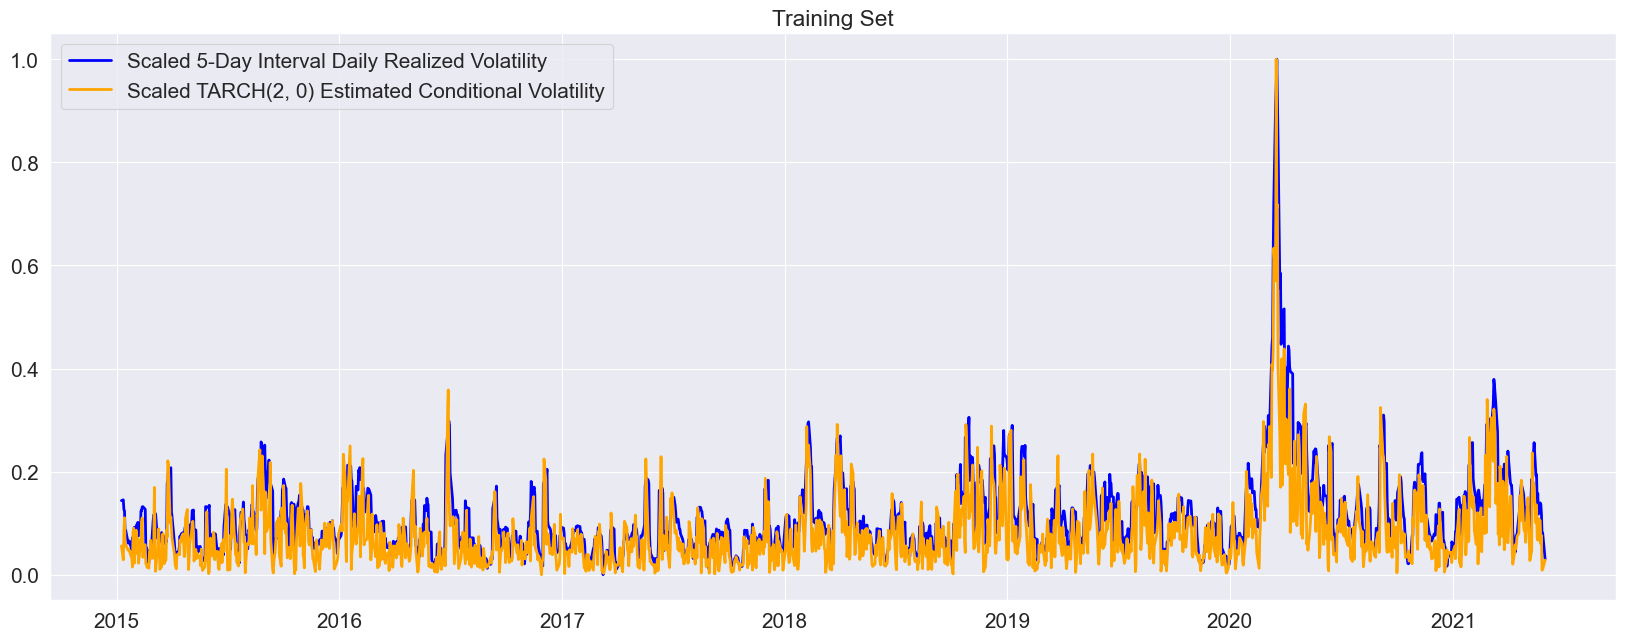

In [123]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [124]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.SOX_Returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=2, q=2, o=0, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [125]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

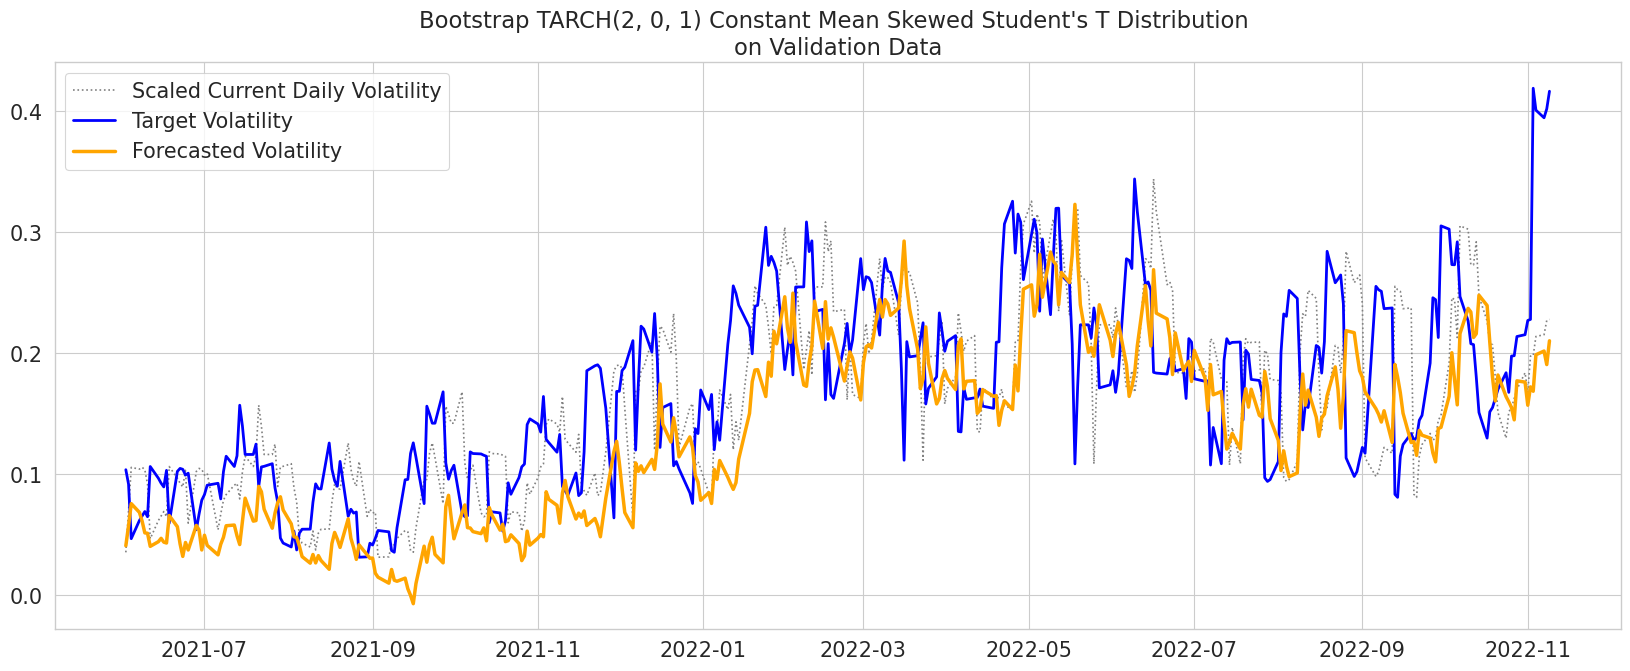

In [126]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.show()

In [127]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.580460   
1                           Random Walk Naive Forecasting          0.544265   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.461228   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.489346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.573575   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.574685   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.456514   

   Validation RMSE  Validation R2  
0         0.093690      -0.458183  
1         0.072320       0.131171  
2         0.070464       0.175174  
3         0.075493       0.053246  
4         0.079306      -0.044808  
5         0.079331      -0.045455  
6         0.073512       0.102287

## 4. Neural Networks

In [128]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import Normalization, Discretization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [129]:
# CONVERT INPUT & OUTPUT SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [130]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [138]:
def forecast(model, range_idx):
    '''
    Generate predictions for a time period 'range_idx' 
    using fitted 'model' with 'n_past' value preassigned
    '''
    #Add +6 in the calculation to set the value length to 365 as the trading in stock exchange is not a uniform daily series
    start_idx = range_idx[0] - timedelta(n_past - 1 + 7) 
    #start_idx = train_idx[split_time_1 - n_past]

    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.Vol_Current_5d[start_idx:end_idx], 
                                    df.Vol_Future_5d[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds


In [132]:
def scale(scaler, y_series):
    '''
    Transform y_series using fitted scaler
    into another series with the same datetime index
    '''
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [133]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

### 4.1 Neural Network Baseline Metrics - Fully Connected Network

In [134]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [135]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

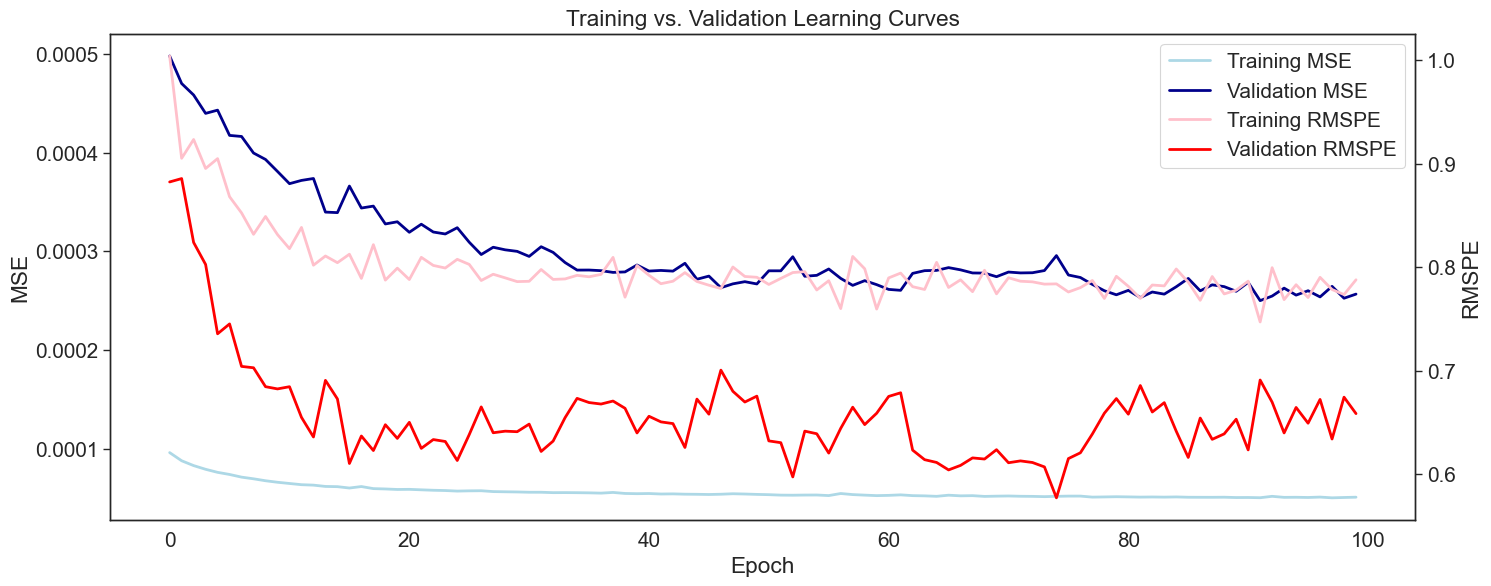

In [136]:
viz_train_val_metrics(snn_1_res)

In [139]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


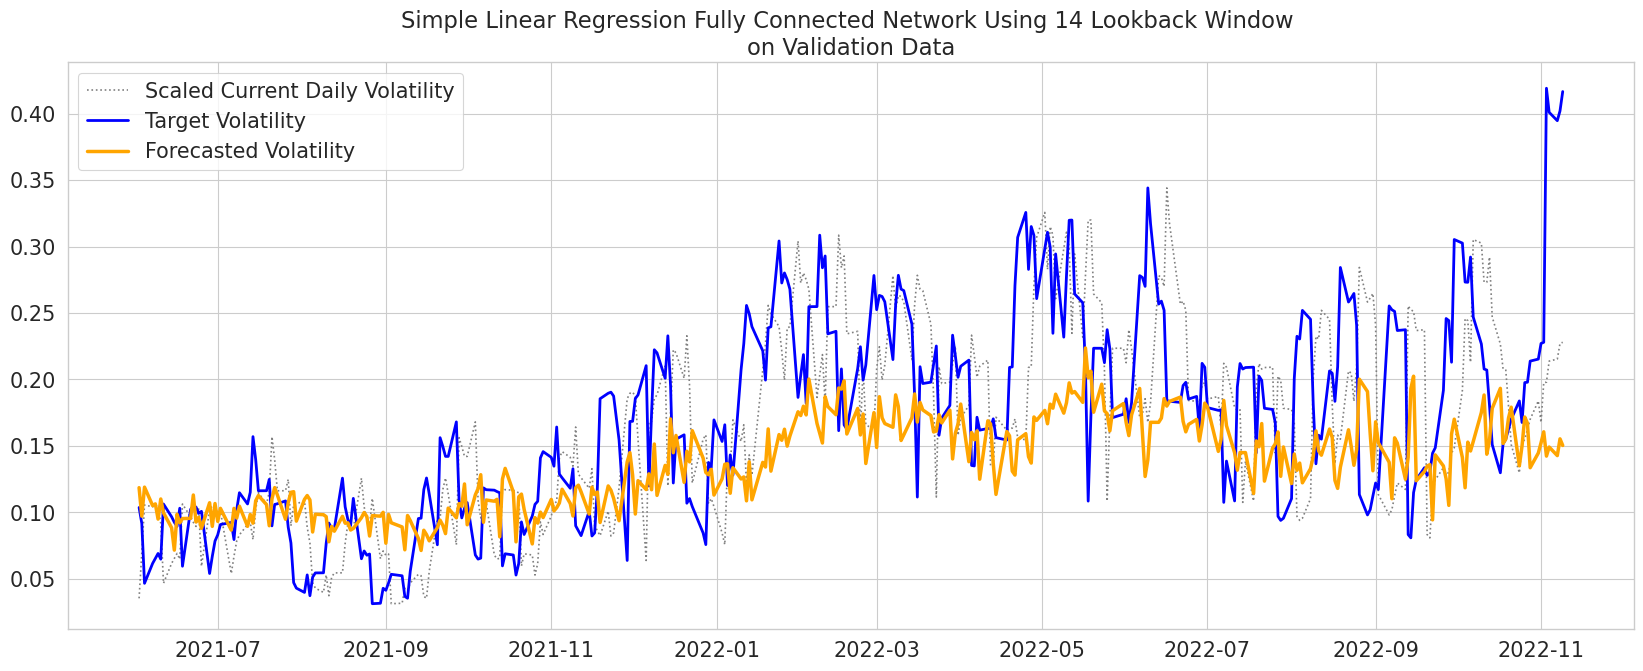

In [140]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")

In [141]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.580460   
1                           Random Walk Naive Forecasting          0.544265   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.461228   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.489346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.573575   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.574685   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.456514   
7                 Simple LR Fully Connected NN, n_past=14          0.469560   

   Validation RMSE  Validation R2  
0         0.093690      -0.458183  
1         0.072320       0.131171  
2         0.070464       0.175174  
3         0.075493       0.053246  
4         0.079306      -0.044808  
5         0.079331      -0.045455  
6         0.073512       0.102287  
7         0.072345       0.130552

### 4.2 Univariate Long Short-Term Memory (LSTM)

In [142]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.keras',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  mode = 'min',
                                  monitor='val_rmspe'
                                 )

print(lstm_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [143]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

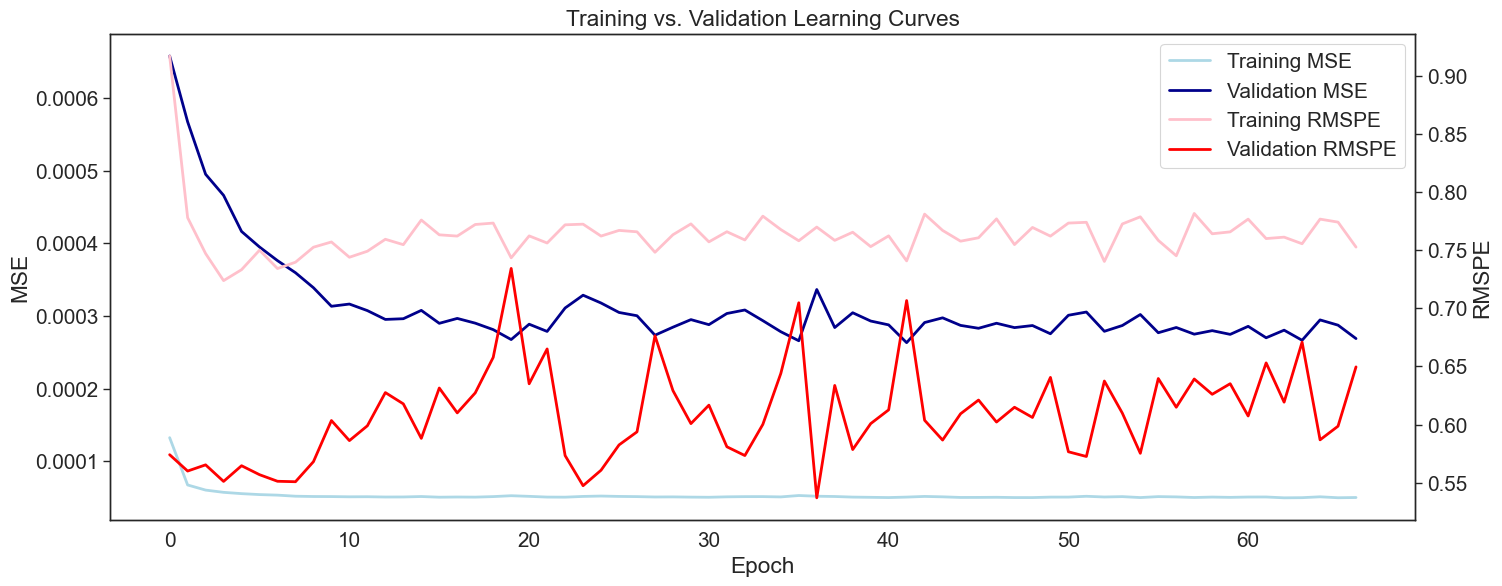

In [144]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

In [145]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


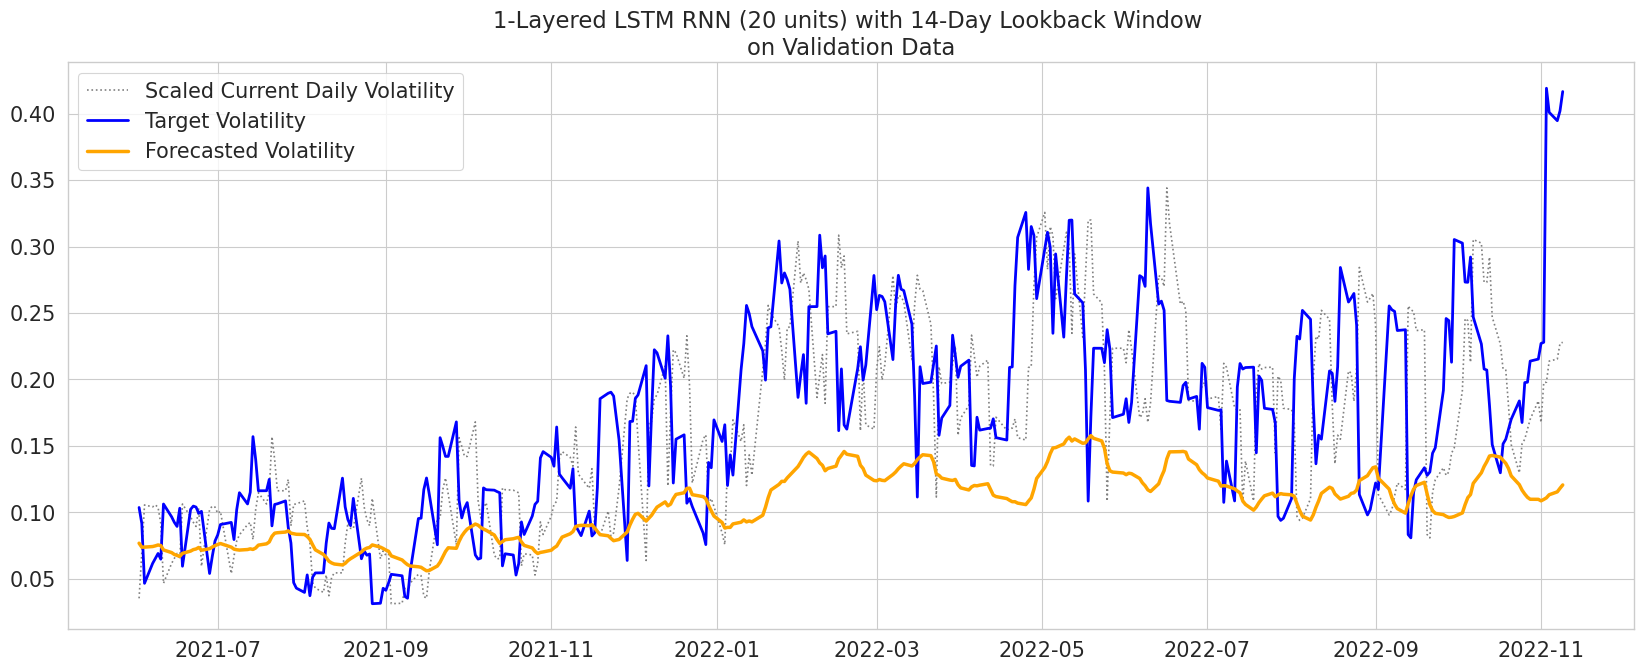

In [146]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

In [147]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.580460   
1                           Random Walk Naive Forecasting          0.544265   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.461228   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.489346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.573575   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.574685   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.456514   
7                 Simple LR Fully Connected NN, n_past=14          0.469560   
8                        LSTM 1 layer 20 units, n_past=14          0.428330   

   Validation RMSE  Validation R2  
0         0.093690      -0.458183  
1         0.072320       0.131171  
2         0.070464       0.175174  
3         0.075493       0.053246  
4         0.079306      -0.044808  
5         0.079331      -0.045455  
6         0.073512       0.102287  
7         0.072345       0.130552  
8         0.091417      -0.388290

### 4.3. Univariate Bidirectional LSTM

In [148]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.keras',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe',
                                  mode ='min')

print(lstm_2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [149]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

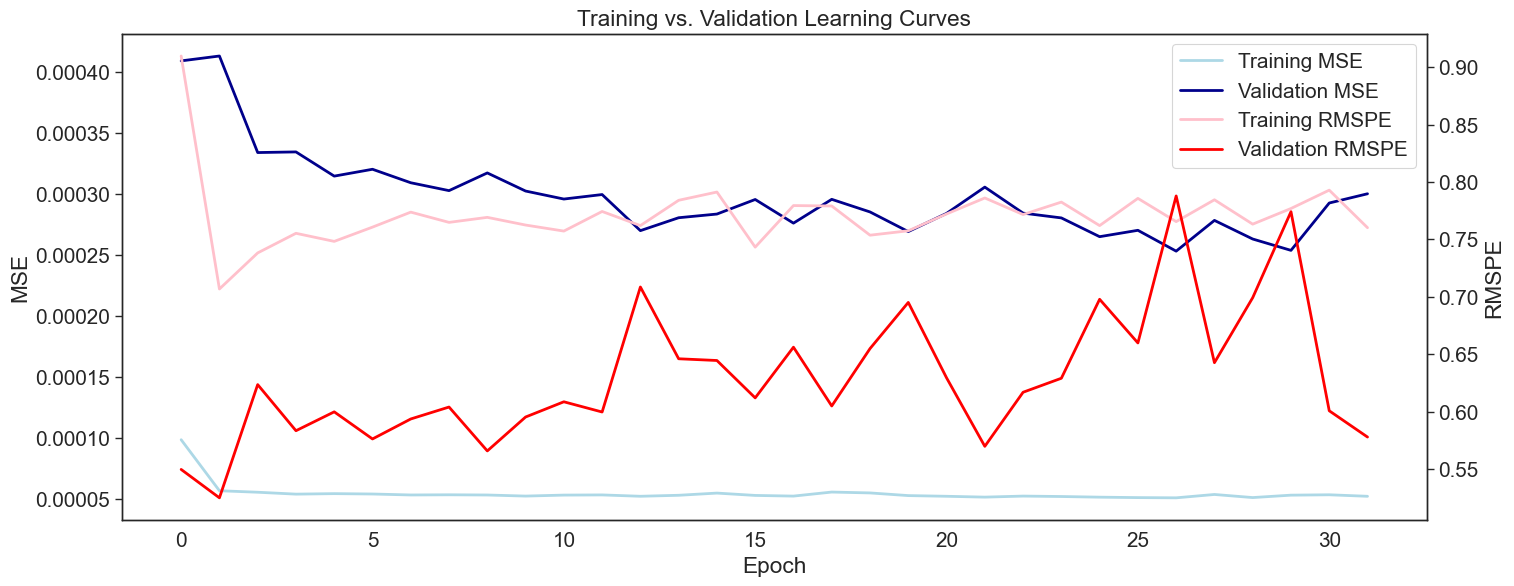

In [150]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [151]:
def forecast2(model, range_idx):
    '''
    Generate predictions for a time period 'range_idx' 
    using fitted 'model' with 'n_past' value preassigned
    '''
    #Add +6 in the calculation to set the value length to 365 as the trading in stock exchange is not a uniform daily series
    start_idx = range_idx[0] - timedelta(n_past - 1 + 13) 

    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.Vol_Current_5d[start_idx:end_idx], 
                                    df.Vol_Future_5d[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [152]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast2(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


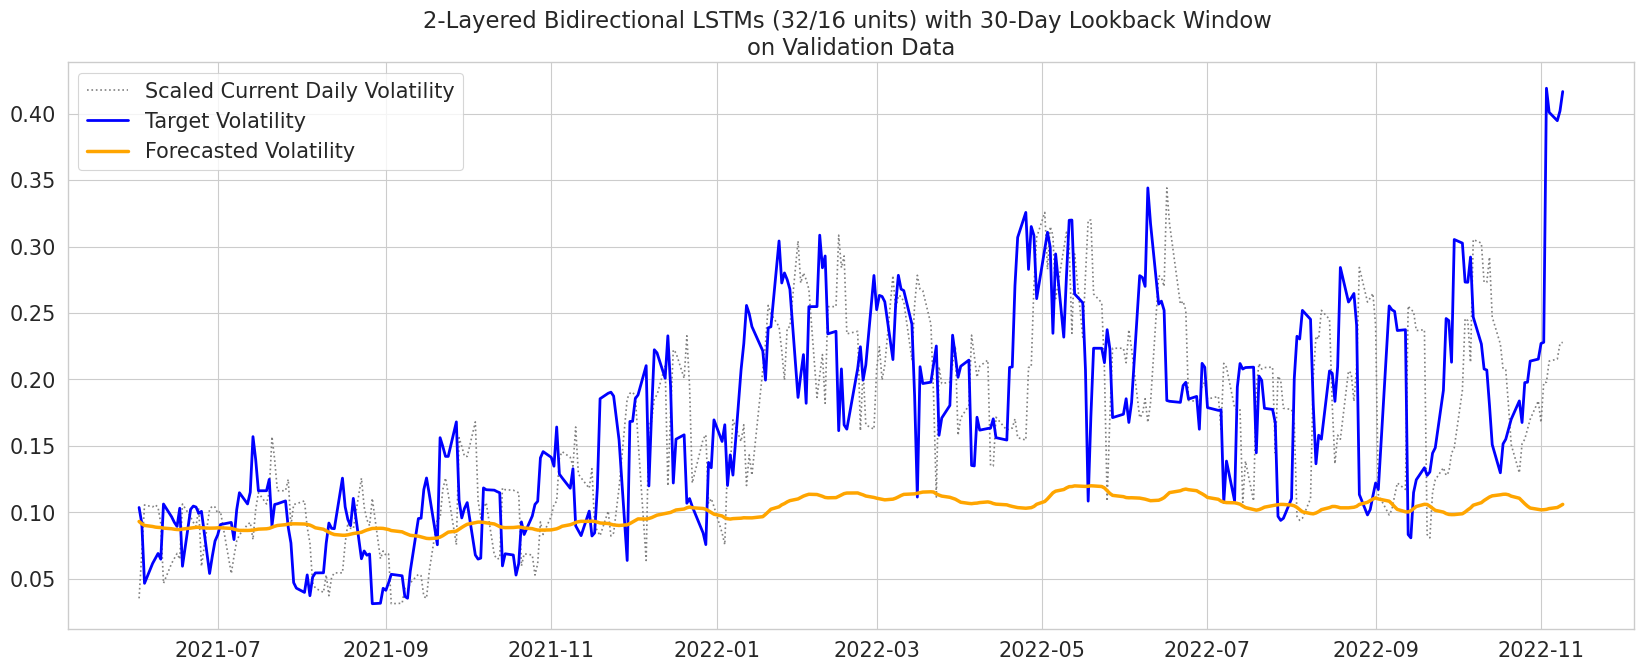

In [153]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")

In [154]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.580460   
1                           Random Walk Naive Forecasting          0.544265   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.461228   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.489346   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.573575   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.574685   
6     Bootstrap TARCH(2, 0, 1), Constant Mean, Skewt Dist          0.456514   
7                 Simple LR Fully Connected NN, n_past=14          0.469560   
8                        LSTM 1 layer 20 units, n_past=14          0.428330   
9         2 layers Bidirect LSTM (32/16 units), n_past=30          0.482985   

   Validation RMSE  Validation R2  
0         0.093690      -0.458183  
1         0.072320       0.131171  
2         0.070464       0.175174  
3         0.075493       0.053246  
4         0.079306      -0.044808  
5         0.079331      -0.045455  
6         0.073512       0.102287  
7         0.072345       0.130552  
8         0.091417      -0.388290  
9         0.099060      -0.630128